# 영화/드라마 데이터 흥행 예측 모델링

## 모델 비교
- LightGBM (최적 선택) → 종합적으로 가장 안정적이며 성능-속도-실용성 균형이 최고
  - 개요: 데이터를 가장 잘 나누는 질문을 빠르게 반복하며 흥행 여부를 판단하는 모델
  - 장점
    - 고차원·희소 피처 처리에 특화 → BERT 임베딩, TF-IDF, 배우 임베딩 모두에 강함
    - RandomForest보다 훨씬 빠르고, XGBoost보다도 가벼움
    - 정확도도 일반적으로 XGBoost와 거의 동급
    - 하이퍼파라미터 기본값도 꽤 안정적
    - 카테고리 인코딩도 자동 지원
  - 단점
    - 데이터가 극단적으로 작은 경우에는 과적합 위험이 있으나, 본 분석 규모에서는 문제가 되지 않음
- XGBoost → 최고 성능 가능성은 있음 but 실용성 낮음 (시도해 보기)
  - 개요: 틀린 예측에 더 집중해가며 이전 모델의 실수를 보완하는 트리 앙상블 모델
  - 장점
    - 전통적으로 성능이 매우 좋음
    - 예측 정확도 탑 클래스
  - 단점
    - 훈련 속도 느림
    - 고차원 피처에 메모리 폭발하기 쉬움
    - 파라미터 복잡 (튜닝 난이도 ↑)
    - 대규모·고차원 데이터에서는 GPU 활용이 사실상 필요함
- MLP (신경망 모델) → 표현력은 높지만 해석성과 실무 안정성 부족
  - 개요: 입력 피처들을 여러 번 섞고 조합하면서 숨겨진 흥행 패턴을 스스로 학습하는 신경망
  - 장점
    - 고차원 연속 피처(텍스트 임베딩) 표현 학습 능력이 뛰어남
    - 비선형 패턴을 잘 학습함
    - 충분한 데이터가 있을 경우 성능 잠재력 큼
  - 단점
    - 스케일링 필수, 전처리 의존도 높음
    - 학습 불안정(초기값·러닝레이트·구조 민감)
    - Feature Importance 해석이 어려움
    - 트리 모델 대비 성능 대비 설명력·안정성이 떨어짐
- RandomForest → 성능 한계가 명확해 뜨는 모델에 미치지 못함 (제외)
  - 개요: 서로 다른 많은 결정나무의 투표로 흥행 여부를 결정하는 안정적인 평균 모델
  - 장점
    - 구현 쉽고 안정적
    - 과적합에 강함
    - 직관적
  - 단점
    - 고차원·희소 벡터(텍스트 임베딩) 처리에 약함
    - 훈련 속도 느림
    - 성능 천장이 빨리 온다
→ LightGBM을 우선적으로, XGBoost, MLP 시도해 보기!


## 모델링 절차

#### (1) 피처 선택
- 영화 데이터
  - movie_main : original_language, release_date, runtime
  - movie_genre : genre
  - movie_country : production_countries
  - movie_emb : overview + genre
  - hit_score : hit_score
- 드라마 데이터
  - drama_main : original_language, first_air_date (데이터 누수 방지를 위해 첫 방영 시점의 계절성만 보고, 시대 효과는 제거)
  - drama_genre : genre
  - drama_country : production_countries
  - drama_emb : overview + genre
  - hit_score : hit_score

#### (2) 피처 엔지니어링
- 타겟(y) 생성: 상위20% = 1, 하위20% = 0, 중간60% 제거
- genre : 멀티 라벨 인코딩
- release_date / first_air_date : month 변환 → 순환 인코딩
- country : 이미 상위 10개국 + other 전처리 되어 있음 → 바로 원핫 인코딩
- language : 원핫 인코딩
- overview + genre : 텍스트 임베딩 (1024차원 그대로 사용) 
- hit_score : 흥행 라벨 생성 후 병합 (데이터 누수 방지)
- Feature Table 병합: 누수 방지 피처(hit_score 등)는 절대 넣지 말기
- 결측치 처리

#### (3) 모델 학습 (LightGBM, XGBoost)
- LightGBM과 XGBoost 두 가지 트리 기반 모델을 활용하여 영화/드라마가 상위 20% 흥행 그룹에 속할 확률(P(hit)) 을 0~1 범위로 예측하는 이진 분류 모델을 구축
- 두 모델의 결과를 비교함으로써 트리 구조 차이에 따른 예측 성능의 안정성과 feature 중요도 해석의 일관성을 검증
- 흥행/비흥행 작품 이진 분류 모델
  - LightGBM
    - 예측 결과
      - hit_probability (0 ~ 1)
        - 콘텐츠의 상대적 흥행 가능성 점수
        - 절대적 흥행 성공/실패가 아닌 동일 데이터셋 내 비교 지표
    - Feature Importance
      - gain
        - 해당 feature가 손실 감소에 기여한 정도 (모델 성능 기여도 해석 핵심)
      - split
        - 해당 feature가 분기(split)에 사용된 빈도 (모델이 얼마나 자주 참고했는지)
      - cover (선택)
        - 해당 feature가 분기 시 얼마나 많은 샘플을 커버했는지 (영향 범위 해석용)
  - XGBoost
    - 예측 결과
      - hit_probability (0 ~ 1)
        - LightGBM과 동일한 정의의 흥행 점수
        - 모델 구조 차이에 따른 결과 안정성 비교용
    - Feature Importance
      - gain
        - 평균적인 손실 감소 기여도 (가장 해석 신뢰도가 높음)
      - weight (= split)
        - 분기 사용 횟수
      - cover
        - 분기에서 사용된 평균 샘플 수

## 흥행 라벨링 이슈: 상위/하위 20%가 맞는가? 

- 영화/드라마는 롱테일 구조라, 하위 20%는 모델이 학습하기에 너무 적음
  - 두 가지 방안
    - 현재 흥행 예측 모델을 흥행 판별 모델로만 쓰기
      - 해석 예시: "드라마 데이터에서는 흥행작을 놓치지 않는 방향으로 학습된 모델이며, 흥행 후보 선별(스크리닝) 용도로 적합하다"
    - 상위/하위 개수 맞추기 (하위 20% -> 늘리기)

<Axes: xlabel='id', ylabel='Count'>

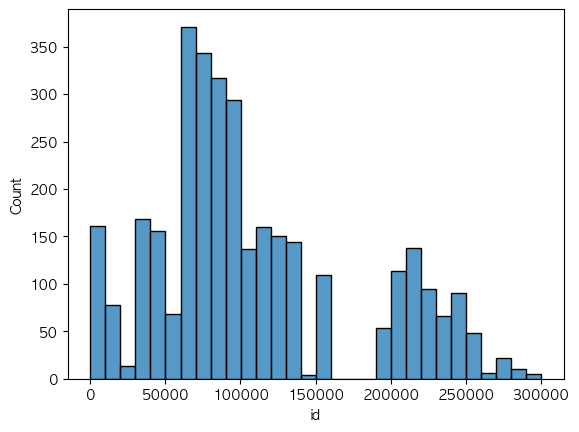

In [ ]:
drama_hit_merged = drama_main.merge(hit_score, on='imdb_id', how='left')
sns.histplot(drama_hit_merged['id'], bins=30)

<Axes: xlabel='id', ylabel='Count'>

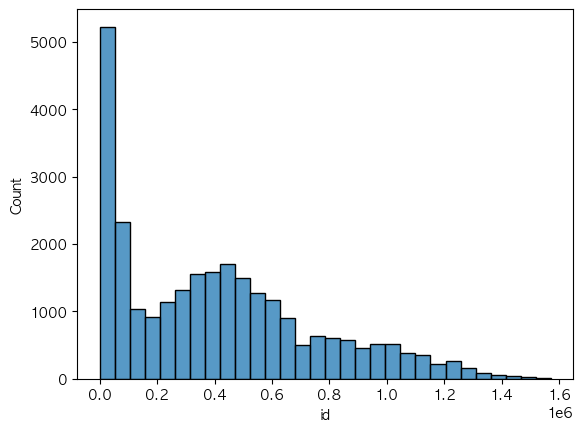

In [ ]:
movie_hit_merged = movie_main.merge(hit_score, on='imdb_id', how='left')
sns.histplot(movie_hit_merged['id'], bins=30)

## 라이브러리 및 파일 불러오기

In [1]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from umap import UMAP
from hdbscan import HDBSCAN
from wordcloud import WordCloud
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
import platform
if platform.system() == 'Windows': # Windows OS
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # mac OS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

mpl.rc('axes', unicode_minus=False) # 축의 음수 부호를 깨지지 않게 설정

# Pandas 출력 옵션 설정
pd.set_option('display.max_columns', None)      # 모든 컬럼 표시
# pd.set_option('display.max_colwidth', None)     # 컬럼 내용 전체 표시 (잘림 방지)
pd.set_option('display.width', None)            # 출력 너비 제한 해제
pd.set_option('display.max_rows', 1000)         # 모든 행 표시

In [ ]:
# 흥행 점수
hit_score = pd.read_parquet('hit_score.parquet')

# 영화 테이블
movie_main = pd.read_parquet('00_movie_main.parquet')
movie_genre = pd.read_parquet('02_movie_genre.parquet')
movie_country = pd.read_parquet('04_movie_country.parquet')
movie_emb  = pd.read_parquet('movie_with_embeddings_final.parquet') # 1024차원

# 드라마 테이블
drama_main = pd.read_parquet('00_drama_main.parquet')
drama_genre = pd.read_parquet('01_drama_genre.parquet')
drama_country = pd.read_parquet('02_drama_country.parquet')
drama_emb = pd.read_parquet('drama_with_embeddings_final.parquet') # 1024차원 

# 데이터 행과 열 개수
print(f"========== 흥행 점수 ==========")
print(f"hit_score: {hit_score.shape}")

print(f"========== 영화 데이터 개수 ==========")
print(f"movie_main: {movie_main.shape}")
print(f"movie_genre: {movie_genre.shape}")
print(f"movie_country: {movie_country.shape}")
print(f"movie_emb: {movie_emb.shape}")

print(f"========== 드라마 데이터 개수 ==========")
print(f"drama_main: {drama_main.shape}")
print(f"drama_genre: {drama_genre.shape}")
print(f"drama_country: {drama_country.shape}")
print(f"drama_emb: {drama_emb.shape}")

========== 흥행 점수 ==========
hit_score: (29271, 5)
========== 영화 데이터 개수 ==========
movie_main: (26971, 15)
movie_genre: (61753, 3)
movie_country: (35506, 2)
movie_emb: (26971, 18)
========== 드라마 데이터 개수 ==========
drama_main: (3317, 32)
drama_genre: (7075, 3)
drama_country: (3472, 2)
drama_emb: (3317, 35)


In [ ]:
drama_country['origin_country'].value_counts()

origin_country
us       1298
other     623
gb        443
kr        440
mx        173
es        119
ca         87
fr         78
tr         74
cn         73
co         64
Name: count, dtype: int64

In [ ]:
drama_country.isna().sum()

imdb_id           0
origin_country    0
dtype: int64

In [ ]:
movie_country['production_countries'].value_counts()

production_countries
united states of america    12562
other                        7429
france                       3540
united kingdom               2909
canada                       1972
germany                      1589
italy                        1313
japan                        1166
india                        1148
spain                         971
belgium                       907
Name: count, dtype: int64

In [ ]:
movie_country.isna().sum()

imdb_id                 0
production_countries    0
dtype: int64

In [ ]:
movie_main['original_language'].unique()

array(['en', 'es', 'xx', 'fr', 'it', 'hi', 'ko', 'ru', 'ja', 'de', 'zh'],
      dtype=object)

## 흥행 예측 모델링

### (1) 영화 데이터 (LightGBM Binary Classification + Feature Importance + SHAP) 

임베딩 컬럼: 1024개

결측치 처리 완료
Final Feature Table Shape: (10517, 1070)
Label balance: {0: 0.5417894836930683, 1: 0.45821051630693166}

Train: (8413, 1068), Valid: (2104, 1068)
Train label 분포: [4558 3855]
Valid label 분포: [1140  964]
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3855, number of negative: 4558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261362
[LightGBM] [Info] Number of data points in the train set: 8413, number of used features: 1066
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458219 -> initscore=-0.167513
[LightGBM] [Info] Start training from score -0.167513
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.906183	valid_0's binary_logloss: 

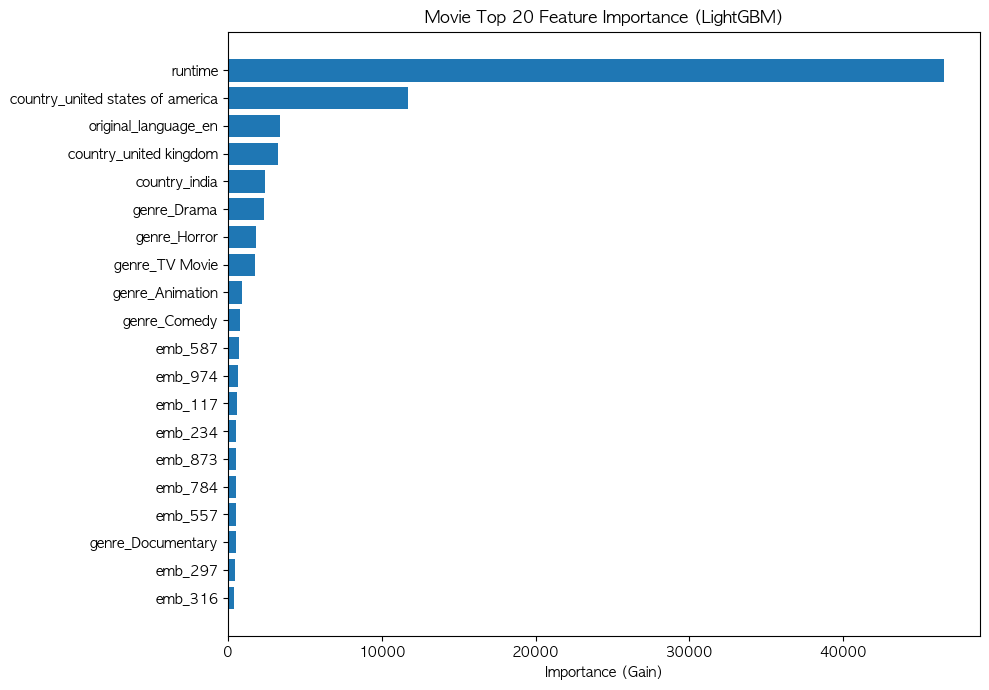

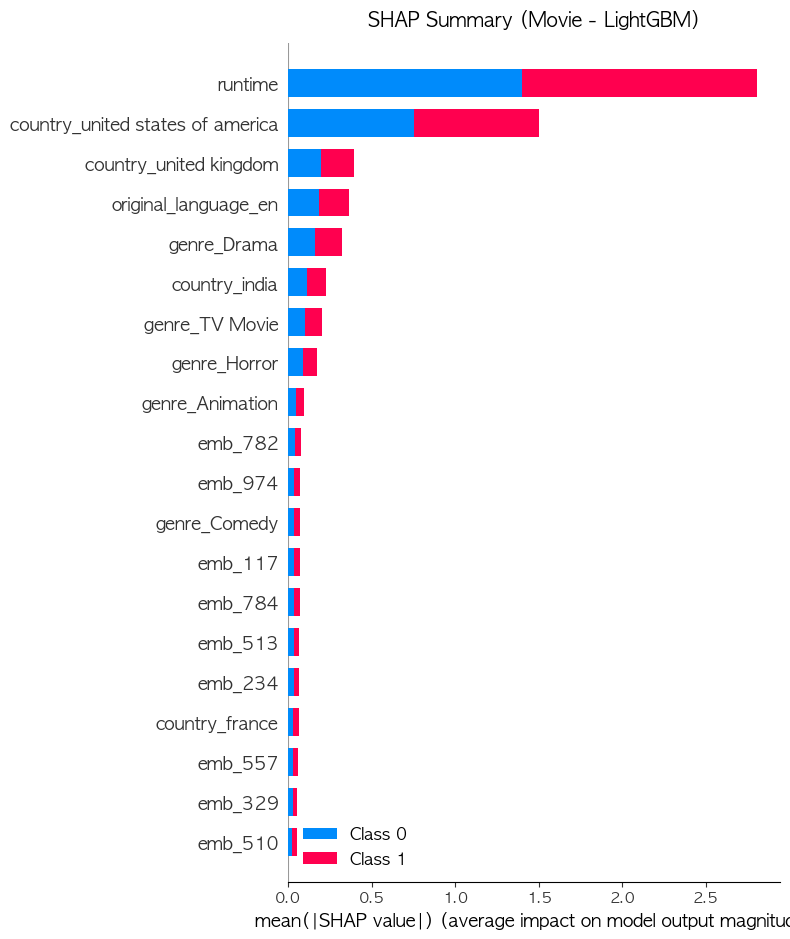

In [ ]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import (
    roc_auc_score, f1_score,
    precision_score, recall_score,
    classification_report
)
import shap
import matplotlib.pyplot as plt

RANDOM_STATE = 42

# ============================================================
# 0. 데이터 로드
# ============================================================
movie_main      = pd.read_parquet('00_movie_main.parquet')
movie_genre     = pd.read_parquet('02_movie_genre.parquet')
movie_country   = pd.read_parquet('04_movie_country.parquet')
movie_emb  = pd.read_parquet('movie_with_embeddings_final.parquet') # 1024차원
hit_score = pd.read_parquet('hit_score.parquet')

# ============================================================
# 1. 타겟(y) 생성: 상위20% = 1, 하위20% = 0, 중간60% 제거
# ============================================================
label = hit_score[["imdb_id", "hit_score"]].dropna().copy()
q80 = label["hit_score"].quantile(0.8)
q20 = label["hit_score"].quantile(0.2)

label["y"] = np.where(label["hit_score"] >= q80, 1,
               np.where(label["hit_score"] <= q20, 0, np.nan))

label = label.dropna(subset=["y"])[["imdb_id", "y"]]
label["y"] = label["y"].astype(int)

# ============================================================
# 2. movie_main: 개봉월 순환 인코딩 + 언어 원핫 + runtime
# ============================================================
main = movie_main[["imdb_id", "original_language", "release_date", "runtime"]].copy()

# release_date -> month 변환 -> 순환 인코딩
main["release_date"] = pd.to_datetime(main["release_date"], errors="coerce")
main["release_month"] = main["release_date"].dt.month

m = main["release_month"].fillna(0)
main["month_sin"] = np.where(m > 0, np.sin(2*np.pi*m/12), 0.0)
main["month_cos"] = np.where(m > 0, np.cos(2*np.pi*m/12), 0.0)

main = main.drop(columns=["release_date", "release_month"])

# original_language 원핫 인코딩
main["original_language"] = main["original_language"].fillna("unk") # fillna("unk") = 값이 없을 때 NaN이 아니라 "정보 없음" 상태가 필요
main = pd.get_dummies(main, columns=["original_language"], drop_first=True)

# ============================================================
# 3. movie_genre: 멀티라벨 인코딩 (MultiLabelBinarizer)
# ============================================================
genre_df = movie_genre.groupby("imdb_id")["genre"].apply(list).reset_index()

mlb = MultiLabelBinarizer()
genre_ohe = mlb.fit_transform(genre_df["genre"])

genre_ohe = pd.DataFrame(genre_ohe, columns=[f"genre_{g}" for g in mlb.classes_])
genre_ohe["imdb_id"] = genre_df["imdb_id"].values

# ============================================================
# 4. movie_country: 이미 상위10 + other 전처리 → 바로 원핫 인코딩
# ============================================================

country = movie_country[["imdb_id", "production_countries"]].copy()

country_ohe = pd.get_dummies(
    country,
    columns=["production_countries"],
    prefix="country",
    drop_first=True
)

country_ohe = country_ohe.groupby("imdb_id", as_index=False).sum()

# ============================================================
# 5. 텍스트 임베딩 전처리 (overview + genre, 1024d)
# ============================================================
movie_emb = movie_emb[['imdb_id', 'embedding']].drop_duplicates("imdb_id")

# 문자열인 경우 리스트로 변환
def to_list(x):
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x

movie_emb["embedding"] = movie_emb["embedding"].apply(to_list)

# 1024개 컬럼으로 펼치기
emb_df = pd.DataFrame(
    movie_emb['embedding'].tolist(),
    columns=[f'emb_{i}' for i in range(1024)]
)

movie_emb = pd.concat([
    movie_emb[['imdb_id']].reset_index(drop=True),
    emb_df
], axis=1)

print(f"임베딩 컬럼: {movie_emb.shape[1] - 1}개")  # 1024개 출력됨

# ============================================================
# 6. Feature Table 병합 (누수 방지: hit_score는 피처에 넣지 않음)
# ============================================================
df = label.merge(main, on="imdb_id", how="inner")
df = df.merge(genre_ohe, on="imdb_id", how="left")
df = df.merge(country_ohe, on="imdb_id", how="left")
df = df.merge(movie_emb, on="imdb_id", how="left")

# ============================================================
# 7. 결측치 처리 (변수 타입별로 다르게)
# ============================================================

# 1) 원-핫 인코딩 변수: NaN → 0으로 채우기 (원핫에서 0=“해당 없음” 의미)
dummy_prefixes = ('genre_', 'country_', 'original_language_')
dummy_cols = [c for c in df.columns if c.startswith(dummy_prefixes)]
df[dummy_cols] = df[dummy_cols].fillna(0)

# 2) 연속형 변수: all-null → 0 + missing flag 처리 (가짜 의미 주입 방지)

# 임베딩
emb_cols = [c for c in df.columns if c.startswith('emb_')]
df["embedding_missing"] = df[emb_cols].isnull().all(axis=1).astype(int)
df[emb_cols] = df[emb_cols].fillna(0)

# runtime
if 'runtime' in df.columns:
    df["runtime_missing"] = df["runtime"].isna().astype(int)
    df["runtime"] = df["runtime"].fillna(0)

# 마지막 남은 결측치 안전하게 처리
remaining_nulls = df.isnull().sum()
if remaining_nulls.sum() > 0:
    print(f"⚠️ 남은 결측치:\n{remaining_nulls[remaining_nulls > 0]}")
    df = df.fillna(0)

print("\n결측치 처리 완료")
print("Final Feature Table Shape:", df.shape)
print("Label balance:", df["y"].value_counts(normalize=True).to_dict())
df.head()

# ============================================================
# 8. Train/Valid Split
# ============================================================
X = df.drop(columns=["imdb_id", "y"])
y = df["y"].values

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(f"\nTrain: {X_train.shape}, Valid: {X_valid.shape}")
print(f"Train label 분포: {np.bincount(y_train)}")
print(f"Valid label 분포: {np.bincount(y_valid)}")

# ============================================================
# 9. LightGBM (Binary Classification)
# ============================================================
lgb_model = lgb.LGBMClassifier(
    objective="binary",
    n_estimators=5000,
    learning_rate=0.03,
    num_leaves=63,
    min_child_samples=30,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(200), lgb.log_evaluation(100)]
)

# ============================================================
# 10. 평가 (분류 지표)
# ============================================================
pred_prob = lgb_model.predict_proba(X_valid)[:, 1]
pred = (pred_prob >= 0.5).astype(int)

print("\n[LGBM] AUC:", roc_auc_score(y_valid, pred_prob))
print("[LGBM] F1 :", f1_score(y_valid, pred))
print("[LGBM] Precision:", precision_score(y_valid, pred))
print("[LGBM] Recall   :", recall_score(y_valid, pred))
print("\n", classification_report(y_valid, pred))

# ============================================================
# 11. Feature Importance (Gain)
# ============================================================
imp = pd.DataFrame({
    "feature": X.columns,
    "gain": lgb_model.booster_.feature_importance(importance_type="gain")
}).sort_values("gain", ascending=False)

top_n = 20
plt.figure(figsize=(10, 7))
plt.barh(imp.head(top_n)["feature"][::-1], imp.head(top_n)["gain"][::-1])
plt.title("Movie Top 20 Feature Importance (LightGBM)")
plt.xlabel("Importance (Gain)")
plt.tight_layout()
plt.show()

# ============================================================
# 12. SHAP 
# ============================================================
explainer = shap.TreeExplainer(lgb_model.booster_)
shap_values = explainer.shap_values(X_valid)

# SHAP plot 생성 (show=False로 제목 추가 가능하게)
shap.summary_plot(
    shap_values, 
    X_valid, 
    max_display=20,
    show=False
)

# 제목 추가
plt.title("SHAP Summary (Movie - LightGBM)", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

### (1-1) 영화 데이터 (XGBoost Binary Classification + Feature Importance + SHAP)

임베딩 컬럼: 1024개

결측치 처리 완료
Final Feature Table Shape: (10517, 1070)
Label balance: {0: 0.5417894836930683, 1: 0.45821051630693166}

Train: (8413, 1068), Valid: (2104, 1068)
Train label 분포: [4558 3855]
Valid label 분포: [1140  964]
[0]	validation_0-auc:0.80128
[100]	validation_0-auc:0.90701
[200]	validation_0-auc:0.91205
[300]	validation_0-auc:0.91420
[400]	validation_0-auc:0.91572
[500]	validation_0-auc:0.91614
[600]	validation_0-auc:0.91622
[700]	validation_0-auc:0.91682
[800]	validation_0-auc:0.91689
[900]	validation_0-auc:0.91676
[1000]	validation_0-auc:0.91683
[1100]	validation_0-auc:0.91710
[1200]	validation_0-auc:0.91698
[1300]	validation_0-auc:0.91729
[1400]	validation_0-auc:0.91733
[1500]	validation_0-auc:0.91745
[1600]	validation_0-auc:0.91740
[1700]	validation_0-auc:0.91742
[1800]	validation_0-auc:0.91730
[1827]	validation_0-auc:0.91721

[XGBoost 성능]
AUC: 0.9175
F1 Score: 0.8316
Precision: 0.8496
Recall: 0.8143

               precision    recall  f1-score   support

           0

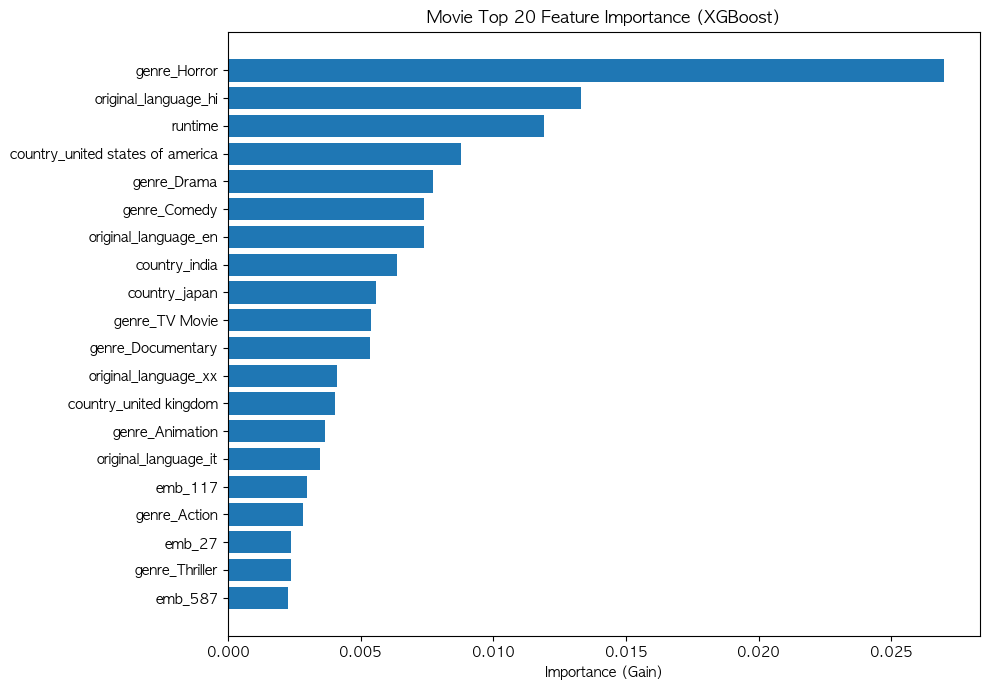

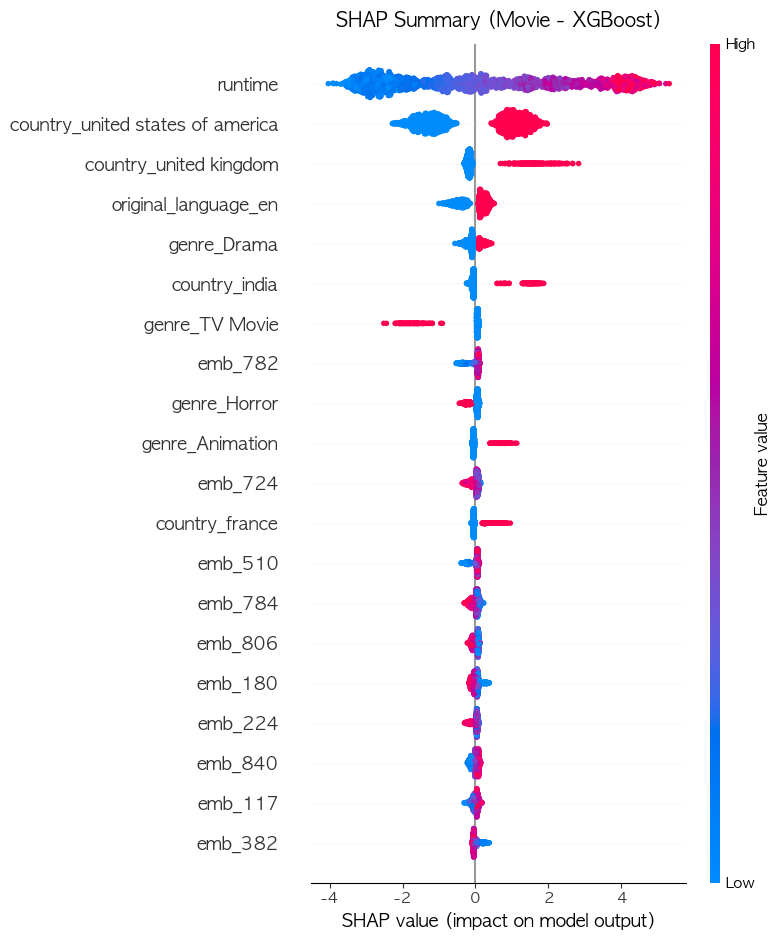

In [72]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import (
    roc_auc_score, f1_score,
    precision_score, recall_score,
    classification_report
)
import shap
import matplotlib.pyplot as plt

RANDOM_STATE = 42

# ============================================================
# 0. 데이터 로드
# ============================================================
movie_main      = pd.read_parquet('00_movie_main.parquet')
movie_genre     = pd.read_parquet('02_movie_genre.parquet')
movie_country   = pd.read_parquet('04_movie_country.parquet')
movie_emb  = pd.read_parquet('movie_with_embeddings_final.parquet') # 1024차원
hit_score = pd.read_parquet('hit_score.parquet')

# ============================================================
# 1. 타겟(y) 생성: 상위20% = 1, 하위20% = 0, 중간60% 제거
# ============================================================
label = hit_score[["imdb_id", "hit_score"]].dropna().copy()
q80 = label["hit_score"].quantile(0.8)
q20 = label["hit_score"].quantile(0.2)

label["y"] = np.where(label["hit_score"] >= q80, 1,
               np.where(label["hit_score"] <= q20, 0, np.nan))

label = label.dropna(subset=["y"])[["imdb_id", "y"]]
label["y"] = label["y"].astype(int)

# ============================================================
# 2. movie_main: 개봉월 순환 인코딩 + 언어 원핫 + runtime
# ============================================================
main = movie_main[["imdb_id", "original_language", "release_date", "runtime"]].copy()

# release_date -> month 변환 -> 순환 인코딩
main["release_date"] = pd.to_datetime(main["release_date"], errors="coerce")
main["release_month"] = main["release_date"].dt.month

m = main["release_month"].fillna(0)
main["month_sin"] = np.where(m > 0, np.sin(2*np.pi*m/12), 0.0)
main["month_cos"] = np.where(m > 0, np.cos(2*np.pi*m/12), 0.0)

main = main.drop(columns=["release_date", "release_month"])

# original_language 원핫 인코딩
main["original_language"] = main["original_language"].fillna("unk") # fillna("unk") = 값이 없을 때 NaN이 아니라 "정보 없음" 상태가 필요
main = pd.get_dummies(main, columns=["original_language"], drop_first=True)

# ============================================================
# 3. movie_genre: 멀티라벨 인코딩 (imdb_id별 genre 리스트 → MultiLabelBinarizer)
# ============================================================
genre_df = movie_genre.groupby("imdb_id")["genre"].apply(list).reset_index()

mlb = MultiLabelBinarizer()
genre_ohe = mlb.fit_transform(genre_df["genre"])

genre_ohe = pd.DataFrame(genre_ohe, columns=[f"genre_{g}" for g in mlb.classes_])
genre_ohe["imdb_id"] = genre_df["imdb_id"].values

# ============================================================
# 4. movie_country: 이미 상위10 + other 전처리 → 바로 원핫 인코딩
# ============================================================

country = movie_country[["imdb_id", "production_countries"]].copy()

country_ohe = pd.get_dummies(
    country,
    columns=["production_countries"],
    prefix="country",
    drop_first=True
)

country_ohe = country_ohe.groupby("imdb_id", as_index=False).sum()

# ============================================================
# 5. 텍스트 임베딩 전처리 (overview + genre, 1024d)
# ============================================================
movie_emb = movie_emb[['imdb_id', 'embedding']].drop_duplicates("imdb_id")

# 문자열인 경우 리스트로 변환
def to_list(x):
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x

movie_emb["embedding"] = movie_emb["embedding"].apply(to_list)

# 1024개 컬럼으로 펼치기
emb_df = pd.DataFrame(
    movie_emb['embedding'].tolist(),
    columns=[f'emb_{i}' for i in range(1024)]
)

movie_emb = pd.concat([
    movie_emb[['imdb_id']].reset_index(drop=True),
    emb_df
], axis=1)

print(f"임베딩 컬럼: {movie_emb.shape[1] - 1}개")  # 1024개 출력됨

# ============================================================
# 6. Feature Table 병합 (누수 방지: hit_score는 피처에 넣지 않음)
# ============================================================
df = label.merge(main, on="imdb_id", how="inner")
df = df.merge(genre_ohe, on="imdb_id", how="left")
df = df.merge(country_ohe, on="imdb_id", how="left")
df = df.merge(movie_emb, on="imdb_id", how="left")

# ============================================================
# 7. 결측치 처리 (변수 타입별로 다르게)
# ============================================================

# 1) 원-핫 인코딩 변수: NaN → 0으로 채우기 (원핫에서 0=“해당 없음” 의미)
dummy_prefixes = ('genre_', 'country_', 'original_language_')
dummy_cols = [c for c in df.columns if c.startswith(dummy_prefixes)]
df[dummy_cols] = df[dummy_cols].fillna(0)

# 2) 연속형 변수: all-null → 0 + missing flag 처리 (가짜 의미 주입 방지)

# 임베딩
emb_cols = [c for c in df.columns if c.startswith('emb_')]
df["embedding_missing"] = df[emb_cols].isnull().all(axis=1).astype(int)
df[emb_cols] = df[emb_cols].fillna(0)

# runtime
if 'runtime' in df.columns:
    df["runtime_missing"] = df["runtime"].isna().astype(int)
    df["runtime"] = df["runtime"].fillna(0)

# 마지막 남은 결측치 안전하게 처리
remaining_nulls = df.isnull().sum()
if remaining_nulls.sum() > 0:
    print(f"⚠️ 남은 결측치:\n{remaining_nulls[remaining_nulls > 0]}")
    df = df.fillna(0)

print("\n결측치 처리 완료")
print("Final Feature Table Shape:", df.shape)
print("Label balance:", df["y"].value_counts(normalize=True).to_dict())
df.head()

# ============================================================
# 8. Train/Valid Split
# ============================================================
X = df.drop(columns=["imdb_id", "y"])
y = df["y"].values

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(f"\nTrain: {X_train.shape}, Valid: {X_valid.shape}")
print(f"Train label 분포: {np.bincount(y_train)}")
print(f"Valid label 분포: {np.bincount(y_valid)}")

# ============================================================
# 9. XGBoost (Binary Classification)
# ============================================================
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=5000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric="auc",
    early_stopping_rounds=200
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=100
)

# ============================================================
# 10. 평가
# ============================================================
pred_prob = xgb_model.predict_proba(X_valid)[:, 1] # 검증 데이터에 대해 양성 클래스(레이블 1) 일 확률을 예측한 값. 이 확률을 그대로 써서 AUC를 계산
pred = (pred_prob >= 0.5).astype(int) # 예측 확률이 0.5 이상이면 1, 아니면 0으로 만들어서 최종 분류 결과(클래스 예측) 를 만든 것 (이 이진 예측을 F1, Precision, Recall 계산에 사용)

print("\n" + "="*60)
print("[XGBoost 성능]")
print("="*60)
print(f"AUC: {roc_auc_score(y_valid, pred_prob):.4f}") # ROC-AUC: decision threshold를 0~1 전 범위에서 움직였을 때의 분류 성능을 한 숫자로 요약한 값. 확률 pred_prob를 넣어서 전체적인 분리 능력(순위 정확도)를 봄
print(f"F1 Score: {f1_score(y_valid, pred):.4f}") # F1 스코어: 정밀도(precision)와 재현율(recall)의 조화평균
print(f"Precision: {precision_score(y_valid, pred):.4f}") # Precision(정밀도): 모델이 1이라고 예측한 것 중에서 실제로 1인 비율. “예측한 양성 중 얼마나 진짜 양성이냐”를 보는 지표
print(f"Recall: {recall_score(y_valid, pred):.4f}") # Recall(재현율): 실제 1인 것들 중에서 모델이 1이라고 잘 잡은 비율. “실제 양성 중 얼마나 놓치지 않고 찾았냐”를 보는 지표
print("\n", classification_report(y_valid, pred)) # 클래스별 precision, recall, F1, support(표본 수)를 한꺼번에 출력

# ============================================================
# 11. Feature Importance
# ============================================================
imp = pd.DataFrame({
    "feature": X.columns,
    "gain": xgb_model.feature_importances_
}).sort_values("gain", ascending=False)

print("\nTop 20 Features:")
print(imp.head(20))

top_n = 20
plt.figure(figsize=(10, 7))
plt.barh(imp.head(top_n)["feature"][::-1], imp.head(top_n)["gain"][::-1])
plt.title("Movie Top 20 Feature Importance (XGBoost)")
plt.xlabel("Importance (Gain)")
plt.tight_layout()
plt.show()

# ============================================================
# 12. SHAP
# ============================================================

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_valid)

# SHAP plot 생성 (show=False로 제목 추가 가능하게)
shap.summary_plot(
    shap_values, 
    X_valid, 
    max_display=20,
    show=False
)

# 제목 추가
plt.title("SHAP Summary (Movie - XGBoost)", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

### (1-2) 영화 데이터 (MLPClassifier + ROC Curve + Permutation Importance)


Label 분포:
y
0    5855
1    5855
Name: count, dtype: int64
Label 비율:
y
0    0.5
1    0.5
Name: proportion, dtype: float64

✅ 임베딩 컬럼: 1024개

병합 후 Shape: (10517, 1068)

✅ 결측치 처리 완료
Final Feature Table Shape: (10517, 1070)

Train: (8413, 1068), Valid: (2104, 1068)
Train label: [4558 3855]
Valid label: [1140  964]

✅ 스케일링 완료
스케일링된 컬럼: 1027개
  - runtime, month_sin, month_cos: 3개
  - 임베딩: 1024개
그대로 둔 컬럼: 41개
  - Missing flags (binary): 2개
  - 원-핫 인코딩: ~38개
Iteration 1, loss = 0.59611891
Validation score: 0.742280
Iteration 2, loss = 0.38674170
Validation score: 0.760095
Iteration 3, loss = 0.27910027
Validation score: 0.749406
Iteration 4, loss = 0.19111394
Validation score: 0.767221
Iteration 5, loss = 0.12424392
Validation score: 0.764846
Iteration 6, loss = 0.07266483
Validation score: 0.787411
Iteration 7, loss = 0.04063036
Validation score: 0.781473
Iteration 8, loss = 0.02241137
Validation score: 0.782660
Iteration 9, loss = 0.01195525
Validation score: 0.783848
Iteration 10, loss = 0.

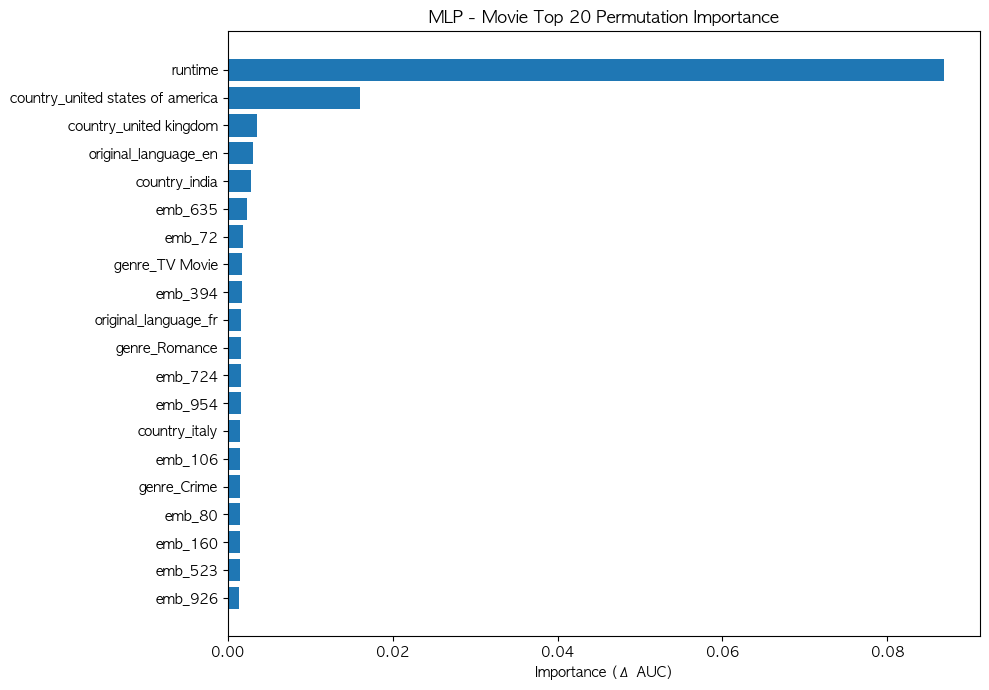


MLP - Movie Top 20 Permutation Importance:
                              feature  importance      group
0                             runtime    0.086921    runtime
41   country_united states of america    0.016059    country
40             country_united kingdom    0.003534    country
3                original_language_en    0.003053   original
35                      country_india    0.002817    country
677                           emb_635    0.002252  embedding
114                            emb_72    0.001814  embedding
28                     genre_TV Movie    0.001743      genre
436                           emb_394    0.001722  embedding
5                original_language_fr    0.001599   original
26                      genre_Romance    0.001579      genre
766                           emb_724    0.001567  embedding
996                           emb_954    0.001544  embedding
36                      country_italy    0.001508    country
148                           emb_106    

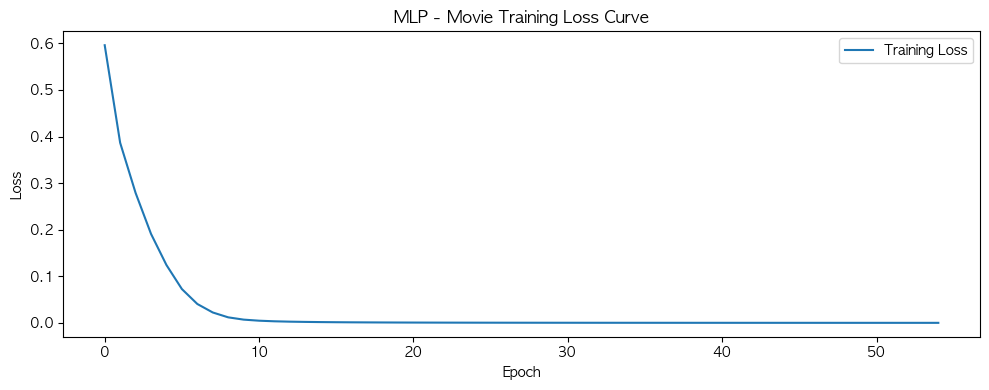

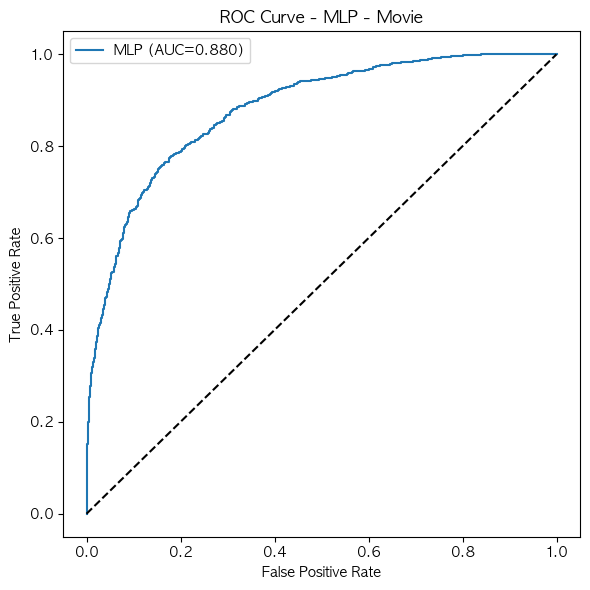

In [65]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    roc_auc_score, f1_score,
    precision_score, recall_score,
    classification_report, roc_curve
)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

RANDOM_STATE = 42

# ============================================================
# 0. 데이터 로드
# ============================================================
movie_main = pd.read_parquet('00_movie_main.parquet')
movie_genre = pd.read_parquet('02_movie_genre.parquet')
movie_country = pd.read_parquet('04_movie_country.parquet')
movie_emb = pd.read_parquet('movie_with_embeddings_final.parquet')
hit_score = pd.read_parquet('hit_score.parquet')

# ============================================================
# 1. 타겟(y) 생성: 상위20% = 1, 하위20% = 0, 중간60% 제거
# ============================================================
label = hit_score[["imdb_id", "hit_score"]].dropna().copy()
q80 = label["hit_score"].quantile(0.8)
q20 = label["hit_score"].quantile(0.2)

label["y"] = np.where(label["hit_score"] >= q80, 1,
               np.where(label["hit_score"] <= q20, 0, np.nan))

label = label.dropna(subset=["y"])[["imdb_id", "y"]]
label["y"] = label["y"].astype(int)

print(f"\nLabel 분포:")
print(label["y"].value_counts())
print(f"Label 비율:")
print(label["y"].value_counts(normalize=True))

# ============================================================
# 2. movie_main: 개봉월 순환 인코딩 + 언어 원핫 + runtime
# ============================================================
main = movie_main[["imdb_id", "original_language", "release_date", "runtime"]].copy()

main["release_date"] = pd.to_datetime(main["release_date"], errors="coerce")
main["release_month"] = main["release_date"].dt.month

m = main["release_month"].fillna(0)
main["month_sin"] = np.where(m > 0, np.sin(2*np.pi*m/12), 0.0)
main["month_cos"] = np.where(m > 0, np.cos(2*np.pi*m/12), 0.0)

main = main.drop(columns=["release_date", "release_month"])

main["original_language"] = main["original_language"].fillna("unk")
main = pd.get_dummies(main, columns=["original_language"], drop_first=True)

# ============================================================
# 3. movie_genre: 멀티라벨 인코딩
# ============================================================
genre_df = movie_genre.groupby("imdb_id")["genre"].apply(list).reset_index()

mlb = MultiLabelBinarizer()
genre_ohe = mlb.fit_transform(genre_df["genre"])

genre_ohe = pd.DataFrame(genre_ohe, columns=[f"genre_{g}" for g in mlb.classes_])
genre_ohe["imdb_id"] = genre_df["imdb_id"].values

# ============================================================
# 4. movie_country: 이미 상위10 + other 전처리 → 바로 원핫 인코딩
# ============================================================

country = movie_country[["imdb_id", "production_countries"]].copy()

country_ohe = pd.get_dummies(
    country,
    columns=["production_countries"],
    prefix="country",
    drop_first=True
)

country_ohe = country_ohe.groupby("imdb_id", as_index=False).sum()

# ============================================================
# 5. 텍스트 임베딩 전처리 (overview + genre, 1024d)
# ============================================================
movie_emb = movie_emb[['imdb_id', 'embedding']].drop_duplicates("imdb_id")

def to_list(x):
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x

movie_emb["embedding"] = movie_emb["embedding"].apply(to_list)

emb_df = pd.DataFrame(
    movie_emb['embedding'].tolist(),
    columns=[f'emb_{i}' for i in range(1024)]
)

movie_emb = pd.concat([
    movie_emb[['imdb_id']].reset_index(drop=True),
    emb_df
], axis=1)

print(f"\n✅ 임베딩 컬럼: {movie_emb.shape[1] - 1}개")

# ============================================================
# 6. Feature Table 병합
# ============================================================
df = label.merge(main, on="imdb_id", how="inner")
df = df.merge(genre_ohe, on="imdb_id", how="left")
df = df.merge(country_ohe, on="imdb_id", how="left")
df = df.merge(movie_emb, on="imdb_id", how="left")

print(f"\n병합 후 Shape: {df.shape}")

# ============================================================
# 7. 결측치 처리
# ============================================================
dummy_prefixes = ('genre_', 'country_', 'original_language_')
dummy_cols = [c for c in df.columns if c.startswith(dummy_prefixes)]
df[dummy_cols] = df[dummy_cols].fillna(0)

emb_cols = [c for c in df.columns if c.startswith('emb_')]
df["embedding_missing"] = df[emb_cols].isnull().all(axis=1).astype(int)
df[emb_cols] = df[emb_cols].fillna(0)

if 'runtime' in df.columns:
    df["runtime_missing"] = df["runtime"].isna().astype(int)
    df["runtime"] = df["runtime"].fillna(0)

remaining_nulls = df.isnull().sum()
if remaining_nulls.sum() > 0:
    print(f"\n⚠️ 남은 결측치:\n{remaining_nulls[remaining_nulls > 0]}")
    df = df.fillna(0)

print("\n✅ 결측치 처리 완료")
print(f"Final Feature Table Shape: {df.shape}")

# ============================================================
# 8. Train/Valid Split
# ============================================================
X = df.drop(columns=["imdb_id", "y"])
y = df["y"].values

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(f"\nTrain: {X_train.shape}, Valid: {X_valid.shape}")
print(f"Train label: {np.bincount(y_train)}")
print(f"Valid label: {np.bincount(y_valid)}")

# ============================================================
# 9. 선택적 스케일링 (연속형 컬럼만)
# ============================================================

# 연속형 컬럼: runtime, month_sin/cos, 임베딩 (1027개)
# 주의: missing flags는 의도적으로 제외 (binary 0/1 값 유지)
continuous_cols = (
    ['runtime', 'month_sin', 'month_cos'] +
    [c for c in X_train.columns if c.startswith('emb_')]
)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_valid_scaled = X_valid.copy()

X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_valid_scaled[continuous_cols] = scaler.transform(X_valid[continuous_cols])

print(f"\n✅ 스케일링 완료")
print(f"스케일링된 컬럼: {len(continuous_cols)}개")
print(f"  - runtime, month_sin, month_cos: 3개")
print(f"  - 임베딩: 1024개")
print(f"그대로 둔 컬럼: {len(X_train.columns) - len(continuous_cols)}개")
print(f"  - Missing flags (binary): 2개")
print(f"  - 원-핫 인코딩: ~38개")

# ============================================================
# 10. MLP 학습
# ============================================================

mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=RANDOM_STATE,
    verbose=True
)

mlp_model.fit(X_train_scaled, y_train)

# ============================================================
# 11. 평가
# ============================================================
pred_prob = mlp_model.predict_proba(X_valid_scaled)[:, 1]
pred = (pred_prob >= 0.5).astype(int)

print("\n" + "="*60)
print("\n[MLP - Movie]")
print("="*60)
print(f"AUC: {roc_auc_score(y_valid, pred_prob):.4f}")
print(f"F1 Score: {f1_score(y_valid, pred):.4f}")
print(f"Precision: {precision_score(y_valid, pred):.4f}")
print(f"Recall: {recall_score(y_valid, pred):.4f}")
print("\n", classification_report(y_valid, pred))

# ============================================================
# 12. Permutation Importance
# ============================================================

# 이미 학습된 mlp 모델 사용 (스케일된 입력을 쓰므로 scaler 제외)
mlp_pipeline = Pipeline([
    ("mlp", mlp_model)
])

result = permutation_importance(
    mlp_pipeline,
    X_valid_scaled,   # 스케일된 데이터
    y_valid,
    n_repeats=3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring="roc_auc"
)

perm_imp = (
    pd.DataFrame({
        "feature": X_valid.columns,
        "importance": result.importances_mean
    })
    .sort_values("importance", ascending=False)
)

# ============================================================
# Feature Group 생성
# ============================================================
perm_imp["group"] = np.where(
    perm_imp["feature"].str.startswith("emb_"),
    "embedding",
    perm_imp["feature"].str.split("_").str[0]
)

group_imp = (
    perm_imp.groupby("group")["importance"]
    .sum()
    .sort_values(ascending=False)
)

# ============================================================
# Top 20 그래프 출력
# ============================================================
plt.figure(figsize=(10, 7))
plt.barh(
    perm_imp.head(20)["feature"][::-1],
    perm_imp.head(20)["importance"][::-1]
)
plt.title("MLP - Movie Top 20 Permutation Importance")
plt.xlabel("Importance (Δ AUC)")
plt.tight_layout()
plt.show()

# ============================================================
# Top 20 텍스트 출력
# ============================================================
print("\nMLP - Movie Top 20 Permutation Importance:")
print(perm_imp.head(20))

print("\n[Permutation Importance by Feature Group]")
print(group_imp)

# ============================================================
# 13. 학습 곡선
# ============================================================
plt.figure(figsize=(10, 4))
plt.plot(mlp_model.loss_curve_, label="Training Loss")
plt.title("MLP - Movie Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 14. ROC Curve
# ============================================================
fpr, tpr, _ = roc_curve(y_valid, pred_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"MLP (AUC={roc_auc_score(y_valid, pred_prob):.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve - MLP - Movie (Validation)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MLP - Movie")
plt.legend()
plt.tight_layout()
plt.show()

#### 영화 데이터 흥행 예측 모델 종합 해석

- 데이터 개요
  - 표본 수: 10,517편
  - 타겟: 흥행 점수 상위 20% = 1, 하위 20% = 0, 중간 60% 제거 → 명확한 흥행/비흥행 대비
  - 입력 피처:
    - 메타 정보 (국가, 언어, 장르, 개봉월, 상영시간)
    - 텍스트 임베딩 1024차원 (줄거리 + 장르)

- 모델 비교
  - ① LightGBM (트리 기반, 성능·안정성·해석력의 균형 모델)
    - 성능
      - AUC: 0.913
      - F1: 0.826
      - Precision: 0.851
      - Recall: 0.802
      → 전반적으로 매우 안정적인 분류 성능
      → Precision과 Recall의 균형이 좋아 흥행작(상위 20%)을 과대·과소 예측하지 않음
    - 주요 해석
      - Feature Importance
        - runtime
        - country_united states of america
        - original_language_en
        - country_united kingdom
        - genre_Drama / Horror / TV Movie
        → 구조적 특징(runtime) + 제작 국가 + 언어 + 장르 조합이 여전히 흥행을 가장 강하게 설명
      - SHAP 분석 결과
        - runtime: 러닝타임이 길수록 흥행 확률 증가 → 극장 상영 영화의 경우 콘텐츠 스케일·서사 밀도를 반영하는 변수로 해석 가능
        - 미국/영국 제작: 해당 국가일수록 Class 1(흥행) 방향으로 SHAP 값 증가 → 글로벌 배급력·마케팅 파워 효과 반영
        - 영어(original_language_en): 글로벌 접근성 → 흥행 가능성 상승
        - 장르: Drama / Horror / TV Movie → 드라마·호러는 흥행 성공 케이스가 비교적 뚜렷, TV Movie는 특정 플랫폼 전략 콘텐츠일 가능성
    - 결론
      - 영화 흥행은 “얼마나 긴 콘텐츠인가” + “어디서 만들어졌는가” + “글로벌 소비가 가능한가”가 핵심 축
      - 임베딩은 보조적 역할을 하되, 구조적 변수의 설명력이 여전히 압도적
  - ② XGBoost (트리 기반, 고성능 중심)
    - 성능
      - AUC: 0.918 (가장 높음)
      - F1: 0.832
      - Precision: 0.850
      - Recall: 0.814
      → 세 모델 중 순위 분리 능력(AUC) 최고
      → 흥행/비흥행 경계 판단에 가장 예민한 모델
    - 주요 해석
      - Feature Importance
        - genre_Horror: 흥행 여부를 가르는 가장 강력한 분기 기준
        - original_language_hi: 인도 시장 기반 대형 흥행작 영향 → 지역 시장 규모가 크면 글로벌 흥행과 무관하게 성공 가능
        - runtime
        - country_united states of america
        - genre_Drama / Comedy
        → LightGBM보다 장르 영향이 더 강하게 부각
      - SHAP 분석 결과
        - runtime: 일정 길이 이상에서 흥행 확률 상승 → 지나치게 짧거나 긴 경우는 불리
        - 미국/영국 제작: LightGBM과 동일하게 긍정적 SHAP 방향
    - 결론
      - 장르 + 언어 + 러닝타임의 비선형 결합을 가장 잘 포착
      - 특정 장르(Horror)나 지역 시장(Hindi)의 “히트 패턴”을 잘 학습한 모델
  - ③ MLPClassifier (신경망) → 메타 정보보다 줄거리·서사 의미(텍스트 임베딩)의 중요성을 보여준 모델
    - 성능
      - AUC: 0.880
      - F1: 0.781
      - Precision: 0.780
      - Recall: 0.781
      → 트리 기반 모델 대비 성능은 낮지만, 임베딩 활용도는 가장 높음
    - 주요 해석
      - Permutation Importance
        - runtime
        - country_united states of america
        - country_united kingdom
        - original_language_en
        - 임베딩 다수 (emb_635, emb_72, emb_394 …)
      - Feature Group 중요도 (집계)
        - embedding = 0.156 (임베딩 중요도 가장 높음) 
        → MLP는 “무엇에 대한 이야기인가(서사/톤)”를 가장 잘 활용
      - Training Loss Curve
        - 초반에 손실이 빠르게 감소하고 안정적으로 수렴 → 과적합 없이 학습이 잘 진행됨
      - ROC Curve(AUC≈0.88)
        - 완만하지만 안정적인 곡선
        → 트리 모델보다 극단적 분리력은 떨어지나, 콘텐츠 의미(embedding) 기반 학습의 효과는 확인됨
    - 결론
      - 콘텐츠의 의미적 특성(임베딩)이 흥행에 가장 큰 기여
      - 구조적 변수보다 “이 영화가 어떤 이야기인가”에 더 민감한 모델

- 종합 결론
  - 세 모델이 서로 다른 관점에서 흥행 공식을 설명함
    - XGBoost : 장르·지역 히트 패턴 포착, 최고 AUC
    - LightGBM : 구조적 변수 해석력, 안정적 성능
    - MLP : 서사·의미(임베딩) 영향 분석에 최적 (보완적 모델)
  - 영화 흥행은 “러닝타임·제작국·언어”가 기본을 만들고, 장르와 서사(임베딩)가 그 위에서 성공 확률을 미세 조정한다.

### (2) 드라마 데이터 (LightGBM Binary Classification + Feature Importance + SHAP)

임베딩 컬럼: 1024개

결측치 처리 완료
Final Feature Table Shape: (1195, 1082)
Label balance: {1: 0.8686192468619247, 0: 0.13138075313807532}

Train: (956, 1080), Valid: (239, 1080)
Train label 분포: [126 830]
Valid label 분포: [ 31 208]
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 830, number of negative: 126
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261168
[LightGBM] [Info] Number of data points in the train set: 956, number of used features: 1041
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.868201 -> initscore=1.885144
[LightGBM] [Info] Start training from score 1.885144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 

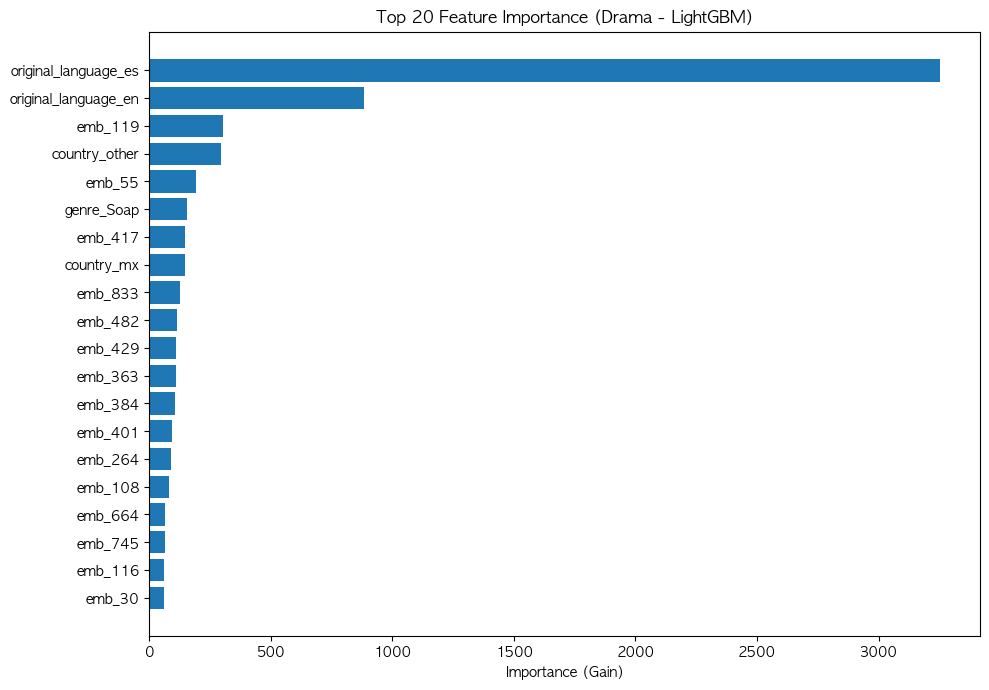

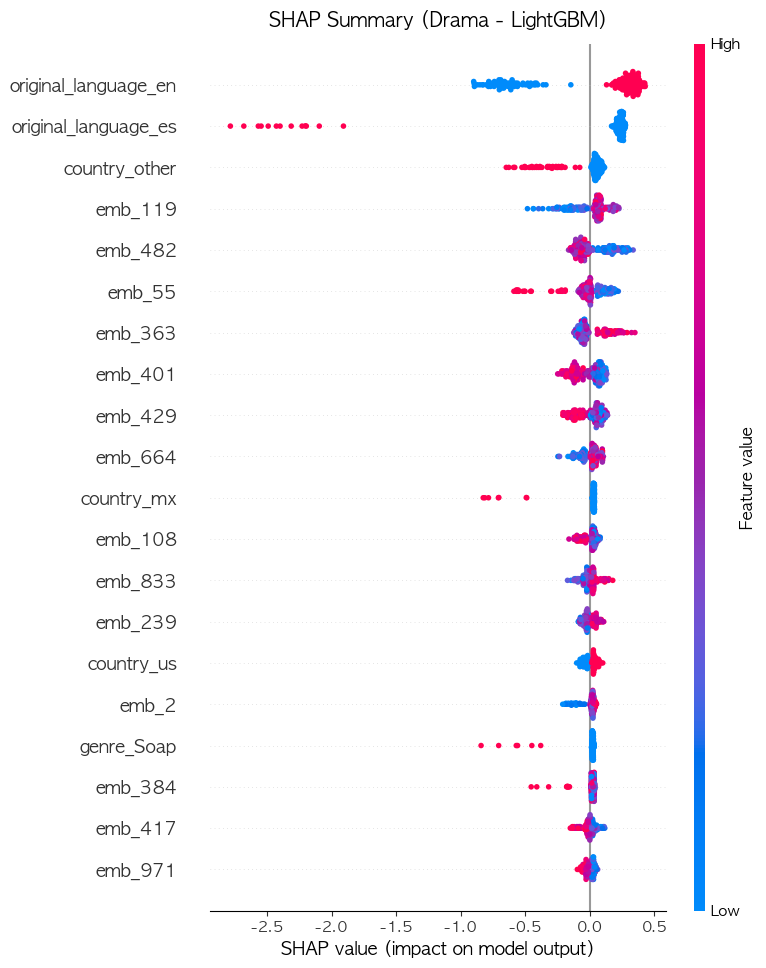

In [42]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import (
    roc_auc_score, f1_score,
    precision_score, recall_score,
    classification_report
)
import shap
import matplotlib.pyplot as plt

RANDOM_STATE = 42

# ============================================================
# 0. 데이터 로드
# ============================================================
drama_main = pd.read_parquet('00_drama_main.parquet')
drama_genre = pd.read_parquet('01_drama_genre.parquet')
drama_country = pd.read_parquet('02_drama_country.parquet')
drama_emb = pd.read_parquet('drama_with_embeddings_final.parquet') # 1024차원 
hit_score = pd.read_parquet('hit_score.parquet')

# ============================================================
# 1. 타겟(y) 생성: 상위20% = 1, 하위20% = 0, 중간60% 제거
# ============================================================
label = hit_score[["imdb_id", "hit_score"]].dropna().copy()
q80 = label["hit_score"].quantile(0.8)
q20 = label["hit_score"].quantile(0.2)

label["y"] = np.where(label["hit_score"] >= q80, 1,
               np.where(label["hit_score"] <= q20, 0, np.nan))

label = label.dropna(subset=["y"])[["imdb_id", "y"]]
label["y"] = label["y"].astype(int)

# ============================================================
# 2. drama_main: 방영 월 순환 인코딩 + 언어 원핫
# ============================================================
main = drama_main[[
    "imdb_id",
    "original_language",
    "first_air_date"
]].copy()

# first_air_date → month → 순환 인코딩
main["first_air_date"] = pd.to_datetime(main["first_air_date"], errors="coerce")
main["first_air_month"] = main["first_air_date"].dt.month

m = main["first_air_month"].fillna(0)
main["month_sin"] = np.where(m > 0, np.sin(2*np.pi*m/12), 0.0)
main["month_cos"] = np.where(m > 0, np.cos(2*np.pi*m/12), 0.0)

main = main.drop(columns=["first_air_date", "first_air_month"])

# original_language 원핫 인코딩
main["original_language"] = (
    main["original_language"]
    .astype("string")   # Categorical → 문자열
    .fillna("unk")
)
main = pd.get_dummies(main, columns=["original_language"], drop_first=True)

# ============================================================
# 3. drama_genre: 멀티라벨 인코딩 (MultiLabelBinarizer)
# ============================================================
genre_df = drama_genre.groupby("imdb_id")["genre"].apply(list).reset_index()

mlb = MultiLabelBinarizer()
genre_ohe = mlb.fit_transform(genre_df["genre"])

genre_ohe = pd.DataFrame(genre_ohe, columns=[f"genre_{g}" for g in mlb.classes_])
genre_ohe["imdb_id"] = genre_df["imdb_id"].values

# ============================================================
# 4. drama_country: 이미 상위10 + other 전처리 → 바로 원핫 인코딩
# ============================================================

country = drama_country[["imdb_id", "origin_country"]].copy()

country_ohe = pd.get_dummies(
    country,
    columns=["origin_country"],
    prefix="country",
    drop_first=True
)

country_ohe = country_ohe.groupby("imdb_id", as_index=False).sum()

# ============================================================
# 5. 텍스트 임베딩 전처리 (overview + genre, 1024d)
# ============================================================
drama_emb = drama_emb[['imdb_id', 'embedding']].drop_duplicates("imdb_id")

# 문자열인 경우 리스트로 변환
def to_list(x):
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x

drama_emb["embedding"] = drama_emb["embedding"].apply(to_list)

# 1024개 컬럼으로 펼치기
emb_df = pd.DataFrame(
    drama_emb['embedding'].tolist(),
    columns=[f'emb_{i}' for i in range(1024)]
)

drama_emb = pd.concat([
    drama_emb[['imdb_id']].reset_index(drop=True),
    emb_df
], axis=1)

print(f"임베딩 컬럼: {drama_emb.shape[1] - 1}개")  # 1024개 출력됨

# ============================================================
# 6. Feature Table 병합 (누수 방지: hit_score는 피처에 넣지 않음)
# ============================================================
df = label.merge(main, on="imdb_id", how="inner")
df = df.merge(genre_ohe, on="imdb_id", how="left")
df = df.merge(country_ohe, on="imdb_id", how="left")
df = df.merge(drama_emb, on="imdb_id", how="left")

# ============================================================
# 7. 결측치 처리 (변수 타입별로 다르게)
# ============================================================

# 1) 원-핫 인코딩 변수: NaN → 0으로 채우기 (원핫에서 0=“해당 없음” 의미)
dummy_prefixes = ('genre_', 'country_', 'original_language_')
dummy_cols = [c for c in df.columns if c.startswith(dummy_prefixes)]
df[dummy_cols] = df[dummy_cols].fillna(0)

# 2) 임베딩: all-null → 0 + missing flag
emb_cols = [c for c in df.columns if c.startswith("emb_")]
df["embedding_missing"] = df[emb_cols].isnull().all(axis=1).astype(int)
df[emb_cols] = df[emb_cols].fillna(0)

# 마지막 남은 결측치 안전하게 처리
remaining_nulls = df.isnull().sum()
if remaining_nulls.sum() > 0:
    print(f"⚠️ 남은 결측치:\n{remaining_nulls[remaining_nulls > 0]}")
    df = df.fillna(0)

print("\n결측치 처리 완료")
print("Final Feature Table Shape:", df.shape)
print("Label balance:", df["y"].value_counts(normalize=True).to_dict())
df.head()

# ============================================================
# 8. Train/Valid Split
# ============================================================
X = df.drop(columns=["imdb_id", "y"])
y = df["y"].values

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(f"\nTrain: {X_train.shape}, Valid: {X_valid.shape}")
print(f"Train label 분포: {np.bincount(y_train)}")
print(f"Valid label 분포: {np.bincount(y_valid)}")

# ============================================================
# 9. LightGBM (Binary Classification)
# ============================================================
lgb_model = lgb.LGBMClassifier(
    objective="binary",
    n_estimators=5000,
    learning_rate=0.03,
    num_leaves=63,
    min_child_samples=30,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(200), lgb.log_evaluation(100)]
)

# ============================================================
# 10. 평가 (분류 지표)
# ============================================================
pred_prob = lgb_model.predict_proba(X_valid)[:, 1]
pred = (pred_prob >= 0.5).astype(int)

print("\n[LGBM] AUC:", roc_auc_score(y_valid, pred_prob))
print("[LGBM] F1 :", f1_score(y_valid, pred))
print("[LGBM] Precision:", precision_score(y_valid, pred))
print("[LGBM] Recall   :", recall_score(y_valid, pred))
print("\n", classification_report(y_valid, pred))

# ============================================================
# 11. Feature Importance (Gain)
# ============================================================
imp = pd.DataFrame({
    "feature": X.columns,
    "gain": lgb_model.booster_.feature_importance(importance_type="gain")
}).sort_values("gain", ascending=False)

top_n = 20
plt.figure(figsize=(10, 7))
plt.barh(imp.head(top_n)["feature"][::-1], imp.head(top_n)["gain"][::-1])
plt.title("Top 20 Feature Importance (Drama - LightGBM)")
plt.xlabel("Importance (Gain)")
plt.tight_layout()
plt.show()

# ============================================================
# 12. SHAP (Binary)
# ============================================================
explainer = shap.TreeExplainer(lgb_model.booster_)
shap_values = explainer.shap_values(X_valid)

# shap_values가 list로 나오면 (클래스별) 1번 클래스(흥행=1)를 사용
if isinstance(shap_values, list):
    shap_values_plot = shap_values[1]
else:
    shap_values_plot = shap_values

shap.summary_plot(
    shap_values_plot,
    X_valid,
    max_display=20,
    show=False
)

plt.title("SHAP Summary (Drama - LightGBM)", fontsize=14, pad=12)
plt.show()

### (2-1) 드라마 데이터 (XGBoost Binary Classification + Feature Importance + SHAP)

임베딩 컬럼: 1024개

결측치 처리 완료
Final Feature Table Shape: (1195, 1082)
Label balance: {1: 0.8686192468619247, 0: 0.13138075313807532}

Train: (956, 1080), Valid: (239, 1080)
Train label 분포: [126 830]
Valid label 분포: [ 31 208]
[0]	validation_0-auc:0.70844
[100]	validation_0-auc:0.86073
[200]	validation_0-auc:0.86073
[300]	validation_0-auc:0.86104
[346]	validation_0-auc:0.86383

[XGBoost - Drama]
AUC: 0.8687965260545906
F1: 0.9447004608294931
Precision: 0.9070796460176991
Recall: 0.9855769230769231

               precision    recall  f1-score   support

           0       0.77      0.32      0.45        31
           1       0.91      0.99      0.94       208

    accuracy                           0.90       239
   macro avg       0.84      0.65      0.70       239
weighted avg       0.89      0.90      0.88       239



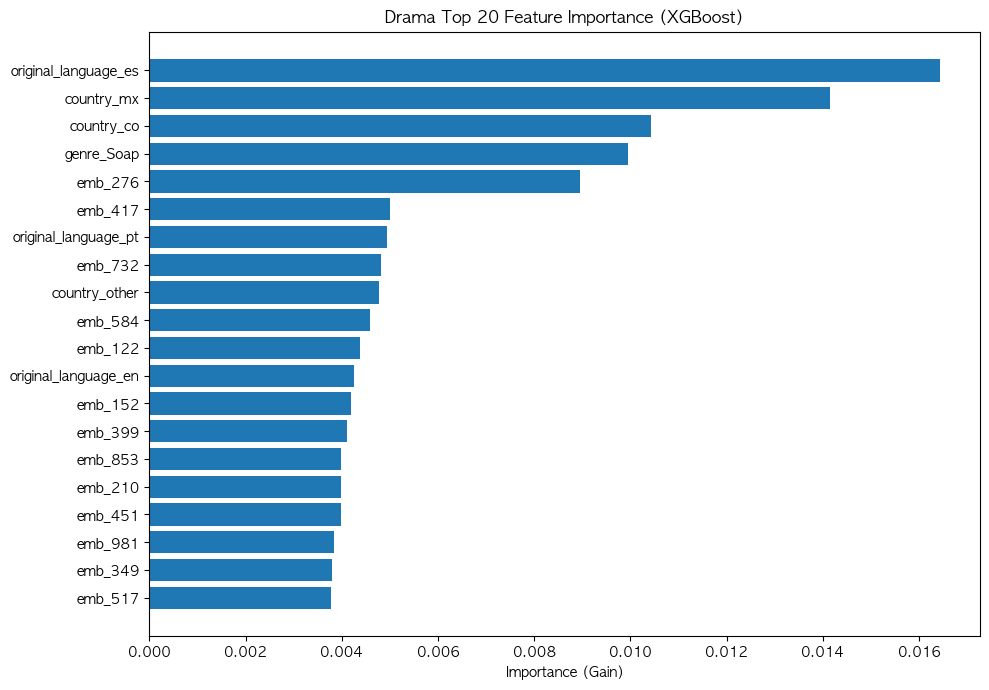

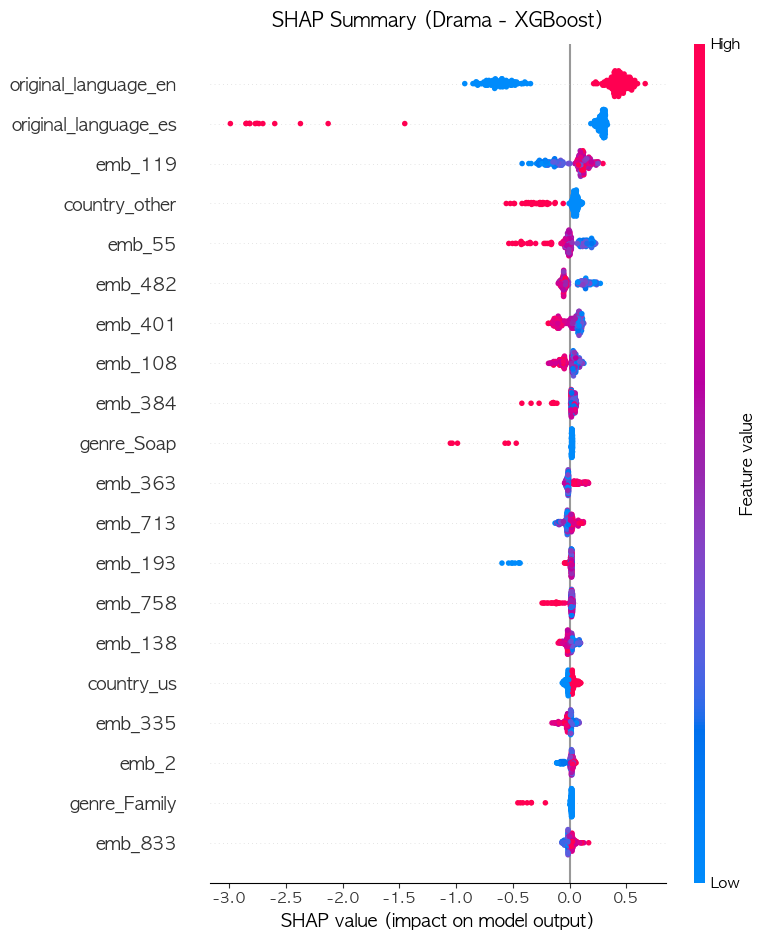

In [70]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import (
    roc_auc_score, f1_score,
    precision_score, recall_score,
    classification_report
)
import shap
import matplotlib.pyplot as plt

RANDOM_STATE = 42

# ============================================================
# 0. 데이터 로드
# ============================================================
drama_main = pd.read_parquet('00_drama_main.parquet')
drama_genre = pd.read_parquet('01_drama_genre.parquet')
drama_country = pd.read_parquet('02_drama_country.parquet')
drama_emb = pd.read_parquet('drama_with_embeddings_final.parquet') # 1024차원 
hit_score = pd.read_parquet('hit_score.parquet')

# ============================================================
# 1. 타겟(y) 생성: 상위20% = 1, 하위20% = 0, 중간60% 제거
# ============================================================
label = hit_score[["imdb_id", "hit_score"]].dropna().copy()
q80 = label["hit_score"].quantile(0.8)
q20 = label["hit_score"].quantile(0.2)

label["y"] = np.where(label["hit_score"] >= q80, 1,
               np.where(label["hit_score"] <= q20, 0, np.nan))

label = label.dropna(subset=["y"])[["imdb_id", "y"]]
label["y"] = label["y"].astype(int)

# ============================================================
# 2. drama_main: 방영 월 순환 인코딩 + 언어 원핫
# ============================================================
main = drama_main[[
    "imdb_id",
    "original_language",
    "first_air_date"
]].copy()

# first_air_date → month → 순환 인코딩
main["first_air_date"] = pd.to_datetime(main["first_air_date"], errors="coerce")
main["first_air_month"] = main["first_air_date"].dt.month

m = main["first_air_month"].fillna(0)
main["month_sin"] = np.where(m > 0, np.sin(2*np.pi*m/12), 0.0)
main["month_cos"] = np.where(m > 0, np.cos(2*np.pi*m/12), 0.0)

main = main.drop(columns=["first_air_date", "first_air_month"])

# original_language 원핫 인코딩
main["original_language"] = (
    main["original_language"]
    .astype("string")   # Categorical → 문자열
    .fillna("unk")
)
main = pd.get_dummies(main, columns=["original_language"], drop_first=True)

# ============================================================
# 3. drama_genre: 멀티라벨 인코딩 (MultiLabelBinarizer)
# ============================================================
genre_df = drama_genre.groupby("imdb_id")["genre"].apply(list).reset_index()

mlb = MultiLabelBinarizer()
genre_ohe = mlb.fit_transform(genre_df["genre"])

genre_ohe = pd.DataFrame(genre_ohe, columns=[f"genre_{g}" for g in mlb.classes_])
genre_ohe["imdb_id"] = genre_df["imdb_id"].values

# ============================================================
# 4. drama_country: 이미 상위10 + other 전처리 → 바로 원핫 인코딩
# ============================================================

country = drama_country[["imdb_id", "origin_country"]].copy()

country_ohe = pd.get_dummies(
    country,
    columns=["origin_country"],
    prefix="country",
    drop_first=True
)

country_ohe = country_ohe.groupby("imdb_id", as_index=False).sum()

# ============================================================
# 5. 텍스트 임베딩 전처리 (overview + genre, 1024d)
# ============================================================
drama_emb = drama_emb[['imdb_id', 'embedding']].drop_duplicates("imdb_id")

# 문자열인 경우 리스트로 변환
def to_list(x):
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x

drama_emb["embedding"] = drama_emb["embedding"].apply(to_list)

# 1024개 컬럼으로 펼치기
emb_df = pd.DataFrame(
    drama_emb['embedding'].tolist(),
    columns=[f'emb_{i}' for i in range(1024)]
)

drama_emb = pd.concat([
    drama_emb[['imdb_id']].reset_index(drop=True),
    emb_df
], axis=1)

print(f"임베딩 컬럼: {drama_emb.shape[1] - 1}개")  # 1024개 출력됨

# ============================================================
# 6. Feature Table 병합 (누수 방지: hit_score는 피처에 넣지 않음)
# ============================================================
df = label.merge(main, on="imdb_id", how="inner")
df = df.merge(genre_ohe, on="imdb_id", how="left")
df = df.merge(country_ohe, on="imdb_id", how="left")
df = df.merge(drama_emb, on="imdb_id", how="left")

# ============================================================
# 7. 결측치 처리 (변수 타입별로 다르게)
# ============================================================

# 1) 원-핫 인코딩 변수: NaN → 0으로 채우기 (원핫에서 0=“해당 없음” 의미)
dummy_prefixes = ('genre_', 'country_', 'original_language_')
dummy_cols = [c for c in df.columns if c.startswith(dummy_prefixes)]
df[dummy_cols] = df[dummy_cols].fillna(0)

# 2) 임베딩: all-null → 0 + missing flag
emb_cols = [c for c in df.columns if c.startswith("emb_")]
df["embedding_missing"] = df[emb_cols].isnull().all(axis=1).astype(int)
df[emb_cols] = df[emb_cols].fillna(0)

# 마지막 남은 결측치 안전하게 처리
remaining_nulls = df.isnull().sum()
if remaining_nulls.sum() > 0:
    print(f"⚠️ 남은 결측치:\n{remaining_nulls[remaining_nulls > 0]}")
    df = df.fillna(0)

print("\n결측치 처리 완료")
print("Final Feature Table Shape:", df.shape)
print("Label balance:", df["y"].value_counts(normalize=True).to_dict())
df.head()

# ============================================================
# 8. Train/Valid Split
# ============================================================
X = df.drop(columns=["imdb_id", "y"])
y = df["y"].values

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(f"\nTrain: {X_train.shape}, Valid: {X_valid.shape}")
print(f"Train label 분포: {np.bincount(y_train)}")
print(f"Valid label 분포: {np.bincount(y_valid)}")

# ============================================================
# 9. XGBoost (Binary Classification)
# ============================================================
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=5000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='auc',
    early_stopping_rounds=200
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=100
)

# ============================================================
# 10. 평가
# ============================================================
pred_prob = xgb_model.predict_proba(X_valid)[:, 1]
pred = (pred_prob >= 0.5).astype(int)

print('\n[XGBoost - Drama]')
print('AUC:', roc_auc_score(y_valid, pred_prob))
print('F1:', f1_score(y_valid, pred))
print('Precision:', precision_score(y_valid, pred))
print('Recall:', recall_score(y_valid, pred))
print('\n', classification_report(y_valid, pred))

# ============================================================
# 11. Feature Importance
# ============================================================
imp = pd.DataFrame({
    'feature': X.columns,
    'gain': xgb_model.feature_importances_
}).sort_values('gain', ascending=False)

plt.figure(figsize=(10, 7))
plt.barh(imp.head(20)['feature'][::-1], imp.head(20)['gain'][::-1])
plt.title('Drama Top 20 Feature Importance (XGBoost)')
plt.xlabel('Importance (Gain)')
plt.tight_layout()
plt.show()

# ============================================================
# 12. SHAP
# ============================================================

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_valid)

# SHAP plot 생성 (show=False로 제목 추가 가능하게)
shap.summary_plot(
    shap_values, 
    X_valid, 
    max_display=20,
    show=False  # 🔴 추가!
)

# 제목 추가
plt.title("SHAP Summary (Drama - XGBoost)", fontsize=14, pad=12)
plt.tight_layout()
plt.show()


### (2-2) 드라마 데이터 (MLPClassifier + ROC Curve + Permutation Importance)

임베딩 컬럼: 1024개

결측치 처리 완료
Final Feature Table Shape: (1195, 1082)
Label balance: {1: 0.8686192468619247, 0: 0.13138075313807532}

Train: (956, 1080), Valid: (239, 1080)
Train label 분포: [126 830]
Valid label 분포: [ 31 208]

✅ 스케일링 완료
스케일링된 컬럼: 1026개
  - month_sin, month_cos: 2개
  - 임베딩: 1024개
그대로 둔 컬럼: 54개
  - Missing flags (binary): 2개
  - 원-핫 인코딩: ~38개
Iteration 1, loss = 0.46258117
Validation score: 0.864583
Iteration 2, loss = 0.20282541
Validation score: 0.864583
Iteration 3, loss = 0.12436315
Validation score: 0.885417
Iteration 4, loss = 0.08160994
Validation score: 0.885417
Iteration 5, loss = 0.05320551
Validation score: 0.885417
Iteration 6, loss = 0.03532043
Validation score: 0.885417
Iteration 7, loss = 0.02532841
Validation score: 0.885417
Iteration 8, loss = 0.01884304
Validation score: 0.875000
Iteration 9, loss = 0.01421979
Validation score: 0.875000
Iteration 10, loss = 0.01099916
Validation score: 0.875000
Iteration 11, loss = 0.00879255
Validation score: 0.885417
Iterat

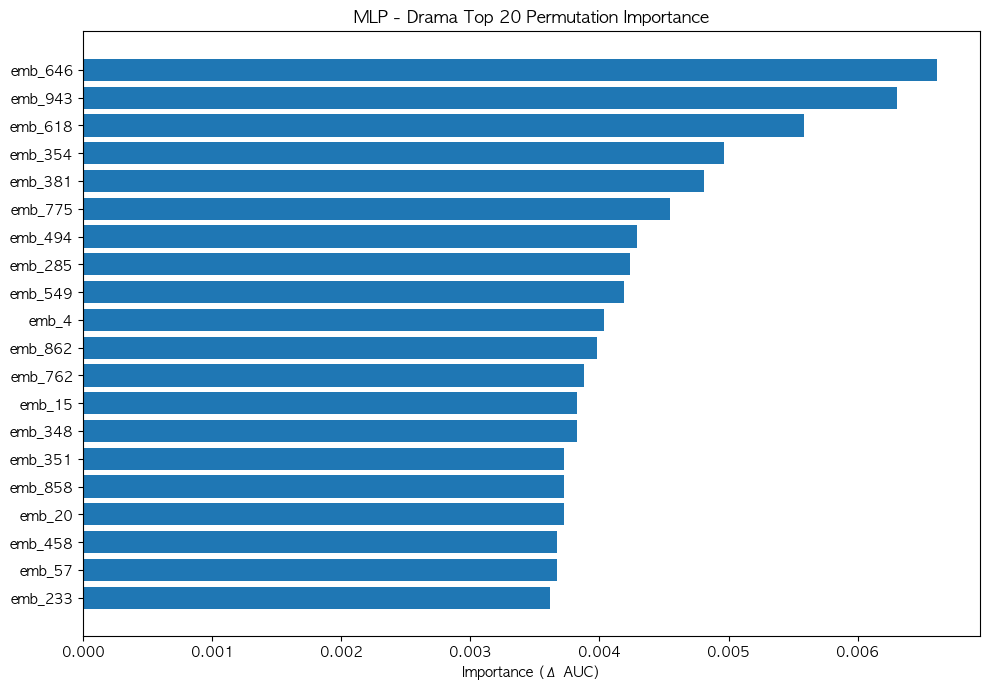


MLP - Drama Top 20 Permutation Importance:
     feature  importance      group
701  emb_646    0.006617  embedding
998  emb_943    0.006307  embedding
673  emb_618    0.005583  embedding
409  emb_354    0.004963  embedding
436  emb_381    0.004808  embedding
830  emb_775    0.004549  embedding
549  emb_494    0.004291  embedding
340  emb_285    0.004239  embedding
604  emb_549    0.004187  embedding
59     emb_4    0.004032  embedding
917  emb_862    0.003981  embedding
817  emb_762    0.003877  embedding
70    emb_15    0.003825  embedding
403  emb_348    0.003825  embedding
406  emb_351    0.003722  embedding
913  emb_858    0.003722  embedding
75    emb_20    0.003722  embedding
513  emb_458    0.003670  embedding
112   emb_57    0.003670  embedding
288  emb_233    0.003619  embedding

[Permutation Importance by Feature Group]
group
embedding    0.677988
original     0.005480
country      0.004136
month        0.003464
genre        0.000207
Name: importance, dtype: float64


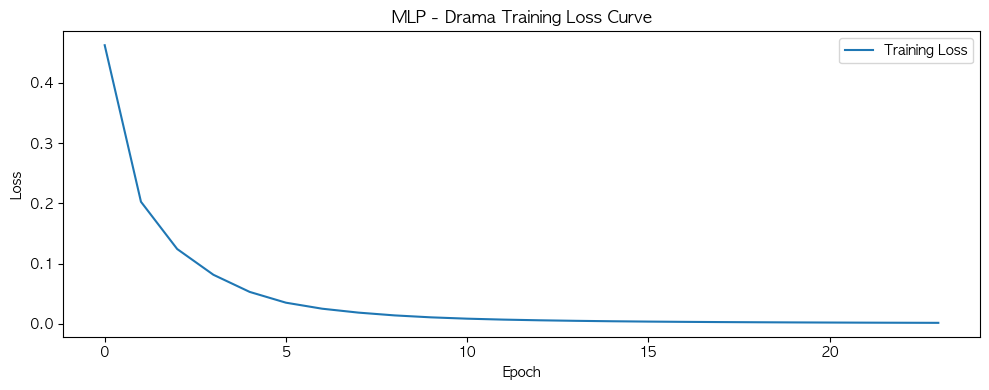

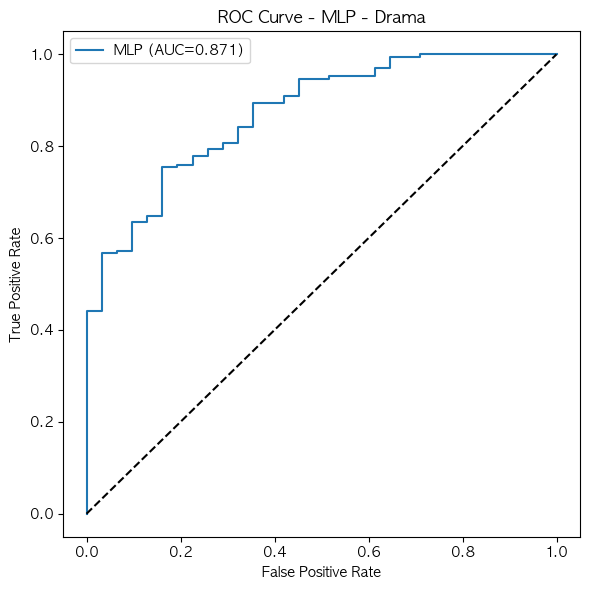

In [67]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    roc_auc_score, f1_score,
    precision_score, recall_score,
    classification_report, roc_curve
)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

RANDOM_STATE = 42

# ============================================================
# 0. 데이터 로드
# ============================================================
drama_main = pd.read_parquet('00_drama_main.parquet')
drama_genre = pd.read_parquet('01_drama_genre.parquet')
drama_country = pd.read_parquet('02_drama_country.parquet')
drama_emb = pd.read_parquet('drama_with_embeddings_final.parquet') # 1024차원 
hit_score = pd.read_parquet('hit_score.parquet')

# ============================================================
# 1. 타겟(y) 생성: 상위20% = 1, 하위20% = 0, 중간60% 제거
# ============================================================
label = hit_score[["imdb_id", "hit_score"]].dropna().copy()
q80 = label["hit_score"].quantile(0.8)
q20 = label["hit_score"].quantile(0.2)

label["y"] = np.where(label["hit_score"] >= q80, 1,
               np.where(label["hit_score"] <= q20, 0, np.nan))

label = label.dropna(subset=["y"])[["imdb_id", "y"]]
label["y"] = label["y"].astype(int)

# ============================================================
# 2. drama_main: 방영 월 순환 인코딩 + 언어 원핫
# ============================================================
main = drama_main[[
    "imdb_id",
    "original_language",
    "first_air_date"
]].copy()

# first_air_date → month → 순환 인코딩
main["first_air_date"] = pd.to_datetime(main["first_air_date"], errors="coerce")
main["first_air_month"] = main["first_air_date"].dt.month

m = main["first_air_month"].fillna(0)
main["month_sin"] = np.where(m > 0, np.sin(2*np.pi*m/12), 0.0)
main["month_cos"] = np.where(m > 0, np.cos(2*np.pi*m/12), 0.0)

main = main.drop(columns=["first_air_date", "first_air_month"])

# original_language 원핫 인코딩
main["original_language"] = (
    main["original_language"]
    .astype("string")   # Categorical → 문자열
    .fillna("unk")
)
main = pd.get_dummies(main, columns=["original_language"], drop_first=True)

# ============================================================
# 3. drama_genre: 멀티라벨 인코딩 (MultiLabelBinarizer)
# ============================================================
genre_df = drama_genre.groupby("imdb_id")["genre"].apply(list).reset_index()

mlb = MultiLabelBinarizer()
genre_ohe = mlb.fit_transform(genre_df["genre"])

genre_ohe = pd.DataFrame(genre_ohe, columns=[f"genre_{g}" for g in mlb.classes_])
genre_ohe["imdb_id"] = genre_df["imdb_id"].values

# ============================================================
# 4. drama_country: 이미 상위10 + other 전처리 → 바로 원핫 인코딩
# ============================================================

country = drama_country[["imdb_id", "origin_country"]].copy()

country_ohe = pd.get_dummies(
    country,
    columns=["origin_country"],
    prefix="country",
    drop_first=True
)

country_ohe = country_ohe.groupby("imdb_id", as_index=False).sum()

# ============================================================
# 5. 텍스트 임베딩 전처리 (overview + genre, 1024d)
# ============================================================
drama_emb = drama_emb[['imdb_id', 'embedding']].drop_duplicates("imdb_id")

# 문자열인 경우 리스트로 변환
def to_list(x):
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x

drama_emb["embedding"] = drama_emb["embedding"].apply(to_list)

# 1024개 컬럼으로 펼치기
emb_df = pd.DataFrame(
    drama_emb['embedding'].tolist(),
    columns=[f'emb_{i}' for i in range(1024)]
)

drama_emb = pd.concat([
    drama_emb[['imdb_id']].reset_index(drop=True),
    emb_df
], axis=1)

print(f"임베딩 컬럼: {drama_emb.shape[1] - 1}개")  # 1024개 출력됨

# ============================================================
# 6. Feature Table 병합 (누수 방지: hit_score는 피처에 넣지 않음)
# ============================================================
df = label.merge(main, on="imdb_id", how="inner")
df = df.merge(genre_ohe, on="imdb_id", how="left")
df = df.merge(country_ohe, on="imdb_id", how="left")
df = df.merge(drama_emb, on="imdb_id", how="left")

# ============================================================
# 7. 결측치 처리 (변수 타입별로 다르게)
# ============================================================

# 1) 원-핫 인코딩 변수: NaN → 0으로 채우기 (원핫에서 0=“해당 없음” 의미)
dummy_prefixes = ('genre_', 'country_', 'original_language_')
dummy_cols = [c for c in df.columns if c.startswith(dummy_prefixes)]
df[dummy_cols] = df[dummy_cols].fillna(0)

# 2) 임베딩: all-null → 0 + missing flag
emb_cols = [c for c in df.columns if c.startswith("emb_")]
df["embedding_missing"] = df[emb_cols].isnull().all(axis=1).astype(int)
df[emb_cols] = df[emb_cols].fillna(0)

# 마지막 남은 결측치 안전하게 처리
remaining_nulls = df.isnull().sum()
if remaining_nulls.sum() > 0:
    print(f"⚠️ 남은 결측치:\n{remaining_nulls[remaining_nulls > 0]}")
    df = df.fillna(0)

print("\n결측치 처리 완료")
print("Final Feature Table Shape:", df.shape)
print("Label balance:", df["y"].value_counts(normalize=True).to_dict())
df.head()

# ============================================================
# 8. Train/Valid Split
# ============================================================
X = df.drop(columns=["imdb_id", "y"])
y = df["y"].values

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(f"\nTrain: {X_train.shape}, Valid: {X_valid.shape}")
print(f"Train label 분포: {np.bincount(y_train)}")
print(f"Valid label 분포: {np.bincount(y_valid)}")

# ============================================================
# 9. 선택적 스케일링 (연속형 컬럼만)
# ============================================================

# 연속형 컬럼: month_sin/cos, 임베딩
# 주의: missing flags는 의도적으로 제외 (binary 0/1 값 유지)
continuous_cols = (
    ['month_sin', 'month_cos'] +
    [c for c in X_train.columns if c.startswith('emb_')]
)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_valid_scaled = X_valid.copy()

X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_valid_scaled[continuous_cols] = scaler.transform(X_valid[continuous_cols])

print(f"\n✅ 스케일링 완료")
print(f"스케일링된 컬럼: {len(continuous_cols)}개")
print(f"  - month_sin, month_cos: 2개")
print(f"  - 임베딩: 1024개")
print(f"그대로 둔 컬럼: {len(X_train.columns) - len(continuous_cols)}개")
print(f"  - Missing flags (binary): 2개")
print(f"  - 원-핫 인코딩: ~38개")

# ============================================================
# 10. MLP 학습
# ============================================================

mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=RANDOM_STATE,
    verbose=True
)

mlp_model.fit(X_train_scaled, y_train)

# ============================================================
# 11. 평가
# ============================================================
pred_prob = mlp_model.predict_proba(X_valid_scaled)[:, 1]
pred = (pred_prob >= 0.5).astype(int)

print("\n" + "="*60)
print("\n[MLP - Drama]")
print("="*60)
print(f"AUC: {roc_auc_score(y_valid, pred_prob):.4f}")
print(f"F1 Score: {f1_score(y_valid, pred):.4f}")
print(f"Precision: {precision_score(y_valid, pred):.4f}")
print(f"Recall: {recall_score(y_valid, pred):.4f}")
print("\n", classification_report(y_valid, pred))

# ============================================================
# 12. Permutation Importance
# ============================================================

# 이미 학습된 mlp 모델 사용 (스케일된 입력을 쓰므로 scaler 제외)
mlp_pipeline = Pipeline([
    ("mlp", mlp_model)
])

result = permutation_importance(
    mlp_pipeline,
    X_valid_scaled,   # 스케일된 데이터
    y_valid,
    n_repeats=3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring="roc_auc"
)

perm_imp = (
    pd.DataFrame({
        "feature": X_valid.columns,
        "importance": result.importances_mean
    })
    .sort_values("importance", ascending=False)
)

# ============================================================
# Feature Group 생성
# ============================================================
perm_imp["group"] = np.where(
    perm_imp["feature"].str.startswith("emb_"),
    "embedding",
    perm_imp["feature"].str.split("_").str[0]
)

group_imp = (
    perm_imp.groupby("group")["importance"]
    .sum()
    .sort_values(ascending=False)
)

# ============================================================
# Top 20 그래프 출력
# ============================================================
plt.figure(figsize=(10, 7))
plt.barh(
    perm_imp.head(20)["feature"][::-1],
    perm_imp.head(20)["importance"][::-1]
)
plt.title("MLP - Drama Top 20 Permutation Importance")
plt.xlabel("Importance (Δ AUC)")
plt.tight_layout()
plt.show()

# ============================================================
# Top 20 텍스트 출력
# ============================================================
print("\nMLP - Drama Top 20 Permutation Importance:")
print(perm_imp.head(20))

print("\n[Permutation Importance by Feature Group]")
print(group_imp)

# ============================================================
# 13. 학습 곡선
# ============================================================
plt.figure(figsize=(10, 4))
plt.plot(mlp_model.loss_curve_, label="Training Loss")
plt.title("MLP - Drama Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 14. ROC Curve
# ============================================================
fpr, tpr, _ = roc_curve(y_valid, pred_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"MLP (AUC={roc_auc_score(y_valid, pred_prob):.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve - MLP - Drama (Validation)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MLP - Drama")
plt.legend()
plt.tight_layout()
plt.show()

#### 드라마 데이터 흥행 예측 모델 종합 해석

- 데이터 개요
  - 표본 수: 1,195개 드라마
  - 타겟 정의: 흥행 점수 상위 20% = 1, 하위 20% = 0, 중간 60% 제거 → 명확한 흥행/비흥행 대비
  - 입력 피처:
    - 메타 정보 (국가, 언어, 장르, 방영월)
    - 텍스트 임베딩 1024차원 (줄거리 + 장르)

- 모델 비교
  - ① LightGBM (트리 기반, 성능·안정성·해석력의 균형 모델)
    - 성능
      - AUC: 0.882
      - F1: 0.947
      - Precision: 0.907
      - Recall: 0.990
      → 흥행 드라마를 거의 빠짐없이 잡아내는 실전형 모델
    - 주요 해석
      - Feature Importance
        - original_language_es
        - original_language_en
        - country_other
        - 임베딩 일부 (emb_119, emb_55, …)
        - genre_Soap
        → 언어 효과가 압도적: 영어(en): 글로벌 접근성 → 흥행 확률 ↑, 스페인어(es): 중남미·스페인권 시장 기반 장기 방영 드라마 구조 반영
        → country_other: 미국/영국 중심이 아닌 로컬 시장 특화 드라마도 흥행 가능
        → genre_Soap: 일일/연속극 구조 → 누적 시청 기반 흥행 패턴
      - SHAP 분석 결과
        - original_language_en: 값이 높을수록 Class 1 방향으로 강한 양의 SHAP
        - original_language_es: 일부 구간에서 음/양 방향 모두 존재 → 시장 이질성
        - 임베딩 피처: 특정 서사 톤/주제 조합이 흥행 확률을 미세 조정
    - 결론
      - 드라마 흥행은 “어떤 언어로 만들어졌는가 + 어느 시장을 타깃으로 했는가”가 가장 큰 1차 결정 요인
      - 그 위에서 서사적 디테일(임베딩)이 흥행 확률을 조정
  - ② XGBoost (트리 기반, 고성능 중심)
    - 성능
      - AUC: 0.869
      - F1: 0.945
      - Precision: 0.907
      - Recall: 0.986
    - 주요 해석
      - Feature Importance
        - original_language_es
        - country_mx, country_co
        - genre_Soap
        - 임베딩 다수
        → 중남미 지역 패턴이 더 강하게 부각: 멕시코/콜롬비아 드라마 = 장기 방영 + 멜로드라마 구조 → 흥행 패턴 명확
        → LightGBM보다 장르 + 지역 결합 효과를 더 공격적으로 사용
      - SHAP 분석 결과
        - 언어·국가 피처의 비선형 경계 효과가 뚜렷
        - 임베딩은 특정 구간에서만 영향 → “이런 이야기면 뜬다”는 조건부 규칙을 학습
    - 결론
      - 드라마 흥행은 “특정 지역 × 특정 장르 조합”에서 강한 히트 패턴이 반복됨
      → XGBoost는 이 패턴을 가장 예민하게 포착
  - ③ MLPClassifier (신경망) → 메타 정보보다 줄거리·서사 의미(텍스트 임베딩)의 중요성을 보여준 모델
    - 성능
      - AUC: 0.871
      - F1: 0.942
      - Precision: 0.910
      - Recall: 0.976
      → 트리 모델 대비 성능은 약간 낮지만 의미 기반 해석에 최적
    - 주요 해석
      - Permutation Importance
        - Top 20 전부 임베딩(emb_xxx), 메타 변수는 거의 등장하지 않음
      - Feature Group 중요도 (집계)
        - embedding = 0.678 (중요도 최고) 
        → MLP는 압도적으로 서사 의미가 중요 (“어디서 만들었나”보다 “무슨 이야기인가", "어떤 톤인가”에 반응)
      - Training Loss Curve
        - 학습 초반에 손실이 빠르게 감소하고 이후 완만하게 수렴
        - 진동 없이 안정적으로 감소 → 학습 과정이 매우 안정적
        - Early Stopping으로 과적합 없이 적절한 시점에서 학습 종료
      - ROC Curve(AUC≈0.87)
        - 대각선(Random) 대비 명확하게 위쪽 곡선
        - 낮은 False Positive Rate에서도 True Positive Rate가 빠르게 상승 
        → 흥행/비흥행 구분 능력이 우수
    - 결론
      - 드라마 흥행은 콘텐츠의 ‘이야기 구조’와 ‘정서적 톤’이 가장 큰 차이를 만듦
      → MLP는 이 의미적 차이를 가장 잘 활용

- 종합 결론
  - 세 모델이 서로 다른 관점에서 흥행 공식을 설명함
    - XGBoost : 지역·장르 기반 히트 패턴 탐지
    - LightGBM : 구조적 변수 해석력, 안정적 성능
    - MLP : 서사·의미 중심 흥행 메커니즘 해석 (보완적 모델)
  - 드라마 흥행 공식 요약
    - 언어 & 타깃 시장이 1차 결정
      - 영어 / 스페인어 중심
      - 글로벌 vs 로컬 장기 방영 구조
    - 국가 × 장르 조합이 흥행 패턴을 만든다
      - Soap / 멜로드라마 / 연속극
    - 서사적 의미(임베딩)는 드라마에서 특히 중요
      - 영화보다 임베딩 영향력 훨씬 큼
      - “이야기의 결”이 장기 시청을 결정
    → 즉, 드라마 흥행은 어떤 언어·시장에 맞춰졌는지가 기본을 만들고, 그 위에서 ‘이야기의 결’이 시청 지속을 결정한다.